In [22]:
import pandas as pd
import numpy as np
from scipy.stats import skew
from scipy.stats import kurtosis
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from keras.utils import np_utils
import matplotlib.pyplot as plt

In [208]:
train=pd.read_csv('train_features.csv')
train_labels=pd.read_csv('train_labels.csv')
test=pd.read_csv('test_features.csv')
sub=pd.read_csv('sample_submission.csv')

In [209]:
train.isna().sum()

id       0
time     0
acc_x    0
acc_y    0
acc_z    0
gy_x     0
gy_y     0
gy_z     0
dtype: int64

### 함수 지정

In [210]:
def range_func(x):
    max_val = np.max(x) 
    min_val = np.min(x)
    range_val = max_val - min_val #최대값 - 최소값
    return range_val

def iqr_func2(x):
    q3, q1 = np.percentile(x, [20, 80])
    iqr = q3 - q1
    return iqr # 20% - 80%

def iqr_func3(x):
    q3, q1 = np.percentile(x, [40, 60])
    iqr = q3 - q1
    return iqr # 40% - 60%

def iqr_func4(x):
    q3, q1 = np.percentile(x, [15, 95])
    iqr = q3 - q1
    return iqr # 15% - 95%

def preskew(x):
    return skew(x) #왜도

def prekurt(x):
    return kurtosis(x,fisher=True) #첨도

### 벡터값 추가

In [211]:
train['acc_vector']=np.sqrt((train['acc_x'] ** 2) +(train['acc_y'] ** 2)+(train['acc_z'] ** 2)) 
train['gy_vector']=np.sqrt((train['gy_x'] ** 2) +(train['gy_y'] ** 2)+(train['gy_z'] ** 2))

test['acc_vector']=np.sqrt((test['acc_x'] ** 2) +(test['acc_y'] ** 2)+(test['acc_z'] ** 2))
test['gy_vector']=np.sqrt((test['gy_x'] ** 2) +(test['gy_y'] ** 2)+(test['gy_z'] ** 2))

### 자이로스코프 무게중심

In [212]:
train['gy_Centerofgravity']=(train['gy_x']+train['gy_y']+train['gy_z'])/3
test['gy_Centerofgravity']=(test['gy_x']+test['gy_y']+test['gy_z'])/3

### roll, pithch (회전반경)

In [213]:
train['roll'] = np.arctan(train['acc_y']/np.sqrt(train['acc_x'] ** 2 + train['acc_z'] ** 2))
train['pitch'] = np.arctan(train['acc_x']/np.sqrt(train['acc_y'] ** 2 + train['acc_z'] ** 2))
train['gy_roll'] = np.arctan(train['gy_y']/np.sqrt(train['gy_x'] ** 2 + train['gy_z'] ** 2))
train['gy_pitch'] = np.arctan(train['gy_x']/np.sqrt(train['gy_y'] ** 2 + train['gy_z'] ** 2))

test['pitch'] = np.arctan(test['acc_x']/np.sqrt(test['acc_y'] ** 2 + test['acc_z'] ** 2))
test['roll'] = np.arctan(test['acc_y']/np.sqrt(test['acc_x'] ** 2 + test['acc_z'] ** 2))
test['gy_roll'] = np.arctan(test['gy_y']/np.sqrt(test['gy_x'] ** 2 + test['gy_z'] ** 2))
test['gy_pitch'] = np.arctan(test['gy_x']/np.sqrt(test['gy_y'] ** 2 + test['gy_z'] ** 2))

In [214]:
train.head(5)

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,acc_vector,gy_vector,gy_Centerofgravity,roll,pitch,gy_roll,gy_pitch
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112,1.228355,44.010999,-20.938910,-0.146550,1.380095,-0.767200,-0.013443
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216,1.315689,46.403958,-21.254406,-0.151814,1.364146,-1.003661,0.006532
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629,1.343234,50.851423,-24.253157,-0.145773,1.330405,-1.050508,-0.071194
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013,1.330969,60.281107,-26.112956,-0.173958,1.331665,-1.095444,0.045021
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234,1.333070,64.446693,-27.193696,-0.141316,1.350615,-1.116383,0.066565


### 함수변수 추가 후 group by

In [215]:
features = ['id', 'acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z','acc_vector','gy_vector','gy_Centerofgravity','roll','pitch','gy_roll','gy_pitch']

train_preprocess = train[features].groupby('id').agg(['max', 'min', 'mean','std','median',range_func,iqr_func2,iqr_func3,iqr_func4,preskew,prekurt])

test_preprocess = test[features].groupby('id').agg(['max', 'min', 'mean','std','median',range_func,iqr_func2,iqr_func3,iqr_func4,preskew,prekurt])

train_preprocess.columns=[i[0]+'_'+i[1] for i in train_preprocess.columns]
test_preprocess.columns=[i[0]+'_'+i[1] for i in test_preprocess.columns]

train_preprocess

,acc_x_max,acc_x_min,acc_x_mean,acc_x_std,acc_x_median,acc_x_range_func,acc_x_iqr_func2,acc_x_iqr_func3,acc_x_iqr_func4,acc_x_preskew,...,gy_pitch_min,gy_pitch_mean,gy_pitch_std,gy_pitch_median,gy_pitch_range_func,gy_pitch_iqr_func2,gy_pitch_iqr_func3,gy_pitch_iqr_func4,gy_pitch_preskew,gy_pitch_prekurt
id,,,,,,,,,,,,,,,,,,,,,
0,1.344268,0.591940,0.931329,0.191479,0.956149,0.752327,-0.369662,-0.172673,-0.544985,0.106076,...,-1.484783,-0.082483,0.621923,-0.049060,2.977117,-0.982953,-0.247226,-1.925501,0.128560,-0.143170
1,1.234020,-2.156208,-0.766580,0.495528,-0.805767,3.390228,-0.892320,-0.259957,-1.126772,-0.202959,...,-1.325747,0.081622,0.738211,0.077202,2.866306,-1.475187,-0.395792,-1.982914,-0.100541,-1.006218
2,1.219836,-1.142847,0.039836,0.711972,0.140667,2.362683,-1.561197,-0.761086,-1.807555,-0.180743,...,-1.442083,-0.131318,0.350403,-0.116379,2.681002,-0.387218,-0.109436,-0.757699,-0.271634,2.876820
3,-0.622250,-1.417751,-0.887702,0.130899,-0.880343,0.795502,-0.227442,-0.070906,-0.332513,-0.606239,...,-1.527213,0.191994,0.794407,0.266623,3.082571,-1.637564,-0.574426,-2.065111,-0.242322,-1.142099
4,0.599720,-2.429109,-0.659018,0.495170,-0.941146,3.028829,-0.724182,-0.337496,-1.314271,0.491559,...,-1.543132,-0.139377,0.814262,-0.275895,3.099170,-1.563356,-0.461233,-2.327640,0.334137,-0.963076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,0.390798,-1.624711,-0.300454,0.403175,-0.105704,2.015509,-0.734687,-0.024370,-1.151625,-0.922420,...,-1.509370,-0.244533,0.705524,-0.327883,2.979482,-1.333628,-0.434936,-2.016105,0.221518,-0.759062
3121,-0.446650,-1.575455,-0.974298,0.169963,-0.980053,1.128804,-0.202045,-0.015255,-0.452615,-0.111515,...,-1.542327,0.077245,0.915084,0.154060,3.012128,-1.997647,-0.955271,-2.331223,-0.077648,-1.498409
3122,0.744666,-2.578974,-1.114246,0.683789,-1.057063,3.323641,-1.396306,-0.486834,-1.845096,-0.110431,...,-1.547482,-0.039582,0.475328,-0.072507,2.978832,-0.904839,-0.364287,-1.186526,-0.085146,-0.488642


### 운동시작지점과 가속도계, 자이로스코프의 첫 3초의 평균

In [216]:
# 가속도계 첫번째 데이터 -> 운동시작지점
train_acc_head1=pd.DataFrame()
for i in train['id'].unique():
    train_acc_head1=train_acc_head1.append(train[['id','acc_x','acc_y','acc_z']][train[['id','acc_x','acc_y','acc_z']]['id']==i].head(1))
train_acc_head1.columns=['id','first_acc_x','first_acc_y','first_acc_z']
train_acc_head1.set_index('id',inplace=True)

test_acc_head1=pd.DataFrame()
for i in test['id'].unique():
    test_acc_head1=test_acc_head1.append(test[['id','acc_x','acc_y','acc_z']][test[['id','acc_x','acc_y','acc_z']]['id']==i].head(1))
test_acc_head1.columns=['id','first_acc_x','first_acc_y','first_acc_z']
test_acc_head1.set_index('id',inplace=True)

# 가속도계 첫 3초 -> 초반에 급격하게 움직이는 운동과 정적인 운동을 비교
train_acc_head=pd.DataFrame()
for i in train['id'].unique():
    train_acc_head=train_acc_head.append(train[['id','acc_x','acc_y','acc_z']][train[['id','acc_x','acc_y','acc_z']]['id']==i].head(150))
train_acc_head.columns=['id','head_acc_x','head_acc_y','head_acc_z'] #총 600개니까 150개
train_acc_head=train_acc_head.groupby('id').mean() #첫 3초의 가속도 평균

test_acc_head=pd.DataFrame()
for i in test['id'].unique():
    test_acc_head=test_acc_head.append(test[['id','acc_x','acc_y','acc_z']][test[['id','acc_x','acc_y','acc_z']]['id']==i].head(150))
test_acc_head.columns=['id','head_acc_x','head_acc_y','head_acc_z']
test_acc_head=test_acc_head.groupby('id').mean()

train_preprocess=pd.concat([train_preprocess,train_acc_head,train_acc_head1],axis=1)
test_preprocess=pd.concat([test_preprocess,test_acc_head,test_acc_head1],axis=1)

# 자이로스코프 첫 3초
train_gy_head=pd.DataFrame()
for i in train['id'].unique():
    train_gy_head=train_gy_head.append(train[['id','gy_x','gy_y','gy_z']][train[['id','gy_x','gy_y','gy_z']]['id']==i].head(150))
train_gy_head.columns=['id','head_gy_x','head_gy_y','head_gy_z']
train_gy_head=train_gy_head.groupby('id').mean()

test_gy_head=pd.DataFrame()
for i in test['id'].unique():
    test_gy_head=test_gy_head.append(test[['id','gy_x','gy_y','gy_z']][test[['id','gy_x','gy_y','gy_z']]['id']==i].head(150))
test_gy_head.columns=['id','head_gy_x','head_gy_y','head_gy_z']
test_gy_head=test_gy_head.groupby('id').mean()

train_preprocess=pd.concat([train_preprocess,train_gy_head],axis=1)
test_preprocess=pd.concat([test_preprocess,test_gy_head],axis=1)

### Kmeans

In [217]:
model = KMeans(n_clusters=5,random_state=20)
model.fit(train_preprocess)

train_predict = model.predict(train_preprocess)
train_preprocess['cluster']=train_predict

test_predict = model.predict(test_preprocess)
test_preprocess['cluster']=test_predict

In [218]:
#중간점검
train_preprocess #153개

,acc_x_max,acc_x_min,acc_x_mean,acc_x_std,acc_x_median,acc_x_range_func,acc_x_iqr_func2,acc_x_iqr_func3,acc_x_iqr_func4,acc_x_preskew,...,head_acc_x,head_acc_y,head_acc_z,first_acc_x,first_acc_y,first_acc_z,head_gy_x,head_gy_y,head_gy_z,cluster
id,,,,,,,,,,,,,,,,,,,,,
0,1.344268,0.591940,0.931329,0.191479,0.956149,0.752327,-0.369662,-0.172673,-0.544985,0.106076,...,0.930401,-0.204424,-0.357682,1.206087,-0.179371,-0.148447,-2.033206,-7.620945,-1.012112,0
1,1.234020,-2.156208,-0.766580,0.495528,-0.805767,3.390228,-0.892320,-0.259957,-1.126772,-0.202959,...,-0.313634,-0.567014,0.471395,-0.211795,-0.078760,0.854627,-26.182937,8.268198,10.465675,2
2,1.219836,-1.142847,0.039836,0.711972,0.140667,2.362683,-1.561197,-0.761086,-1.807555,-0.180743,...,0.005221,-0.113100,0.600223,0.241388,-0.437876,0.797198,-4.955283,-8.169446,2.694235,4
3,-0.622250,-1.417751,-0.887702,0.130899,-0.880343,0.795502,-0.227442,-0.070906,-0.332513,-0.606239,...,-0.912448,-0.256042,0.108072,-1.066225,-0.280265,0.003342,17.512190,2.476961,-0.595546,4
4,0.599720,-2.429109,-0.659018,0.495170,-0.941146,3.028829,-0.724182,-0.337496,-1.314271,0.491559,...,0.014436,-0.902046,0.173936,0.144852,-1.331613,-1.231836,-20.248809,32.095738,15.112848,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,0.390798,-1.624711,-0.300454,0.403175,-0.105704,2.015509,-0.734687,-0.024370,-1.151625,-0.922420,...,-0.055424,-0.760497,0.320807,0.095092,-0.827868,0.542625,-22.442501,-16.061831,13.936728,4
3121,-0.446650,-1.575455,-0.974298,0.169963,-0.980053,1.128804,-0.202045,-0.015255,-0.452615,-0.111515,...,-1.017820,-0.184831,-0.114710,-0.588936,-0.131407,-0.077380,42.917552,12.480624,-6.834904,0
3122,0.744666,-2.578974,-1.114246,0.683789,-1.057063,3.323641,-1.396306,-0.486834,-1.845096,-0.110431,...,-1.046002,-0.490153,0.235311,-1.327998,-0.385354,0.379149,11.134857,29.792051,-1.994560,1


# 전처리 끝

In [220]:
train_preprocess.head(3)

,acc_x_max,acc_x_min,acc_x_mean,acc_x_std,acc_x_median,acc_x_range_func,acc_x_iqr_func2,acc_x_iqr_func3,acc_x_iqr_func4,acc_x_preskew,...,head_acc_x,head_acc_y,head_acc_z,first_acc_x,first_acc_y,first_acc_z,head_gy_x,head_gy_y,head_gy_z,cluster
id,,,,,,,,,,,,,,,,,,,,,
0,1.344268,0.591940,0.931329,0.191479,0.956149,0.752327,-0.369662,-0.172673,-0.544985,0.106076,...,0.930401,-0.204424,-0.357682,1.206087,-0.179371,-0.148447,-2.033206,-7.620945,-1.012112,0
1,1.234020,-2.156208,-0.766580,0.495528,-0.805767,3.390228,-0.892320,-0.259957,-1.126772,-0.202959,...,-0.313634,-0.567014,0.471395,-0.211795,-0.078760,0.854627,-26.182937,8.268198,10.465675,2
2,1.219836,-1.142847,0.039836,0.711972,0.140667,2.362683,-1.561197,-0.761086,-1.807555,-0.180743,...,0.005221,-0.113100,0.600223,0.241388,-0.437876,0.797198,-4.955283,-8.169446,2.694235,4


In [13]:
!pip install imbalanced-learn

You should consider upgrading via the 'c:\users\lsj70\anaconda3\python.exe -m pip install --upgrade pip' command.


In [14]:
#x_split_train, x_split_test, y_split_train, y_split_test = train_test_split(train_preprocess,train_labels['label'], test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test

In [17]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV

strategy : minority
최적 하이퍼 파라미터:  {'max_depth': 11, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.8076


<BarContainer object of 61 artists>

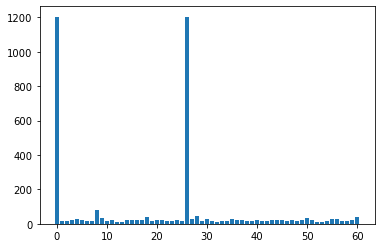

In [18]:
random_over=RandomOverSampler(sampling_strategy='minority')
X_ran_over, y_ran_over = random_over.fit_resample(x_split_train, y_split_train)

params = { 'n_estimators' : [10,30,50,70,90, 100],
       'max_depth' : [5,7,9,11],
       'min_samples_leaf' : [8,10, 12,14,16,18],
       'min_samples_split' : [8,10,12,14,16,18,20]
        }

ran2_grid_train = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(ran2_grid_train, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X_ran_over, y_ran_over)
print('strategy : minority')
print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))
plt.bar(y_ran_over.value_counts().index,y_ran_over.value_counts())

In [25]:
y_split_train.value_counts()

26    1204
8       78
28      43
18      40
60      40
      ... 
12      11
53      10
52       8
13       8
0        8
Name: label, Length: 61, dtype: int64

In [ ]:
정지

In [ ]:
train.head(3)

In [ ]:
train_data = train.iloc[:,2:].copy()
train_s = []

for i in range(int(len(train_data)/600)):
    train_s.append(train_data[(i*600):((i+1)*600)])
    
train_arr = [np.array(i) for i in train_s]
train_arr_3d = np.array(train_arr)

In [ ]:
test_data = test.iloc[:,2:].copy()
test_s = []
for i in range(int(len(test_data)/600)):
    test_s.append(test_data[(i*600):((i+1)*600)])

test_arr = [np.array(i) for i in test_s]
test_arr_3d = np.array(test_arr)

In [ ]:
print(train_arr_3d.shape)
print(test_arr_3d.shape)
print(train_labels.shape)

 **Label별로 8:2 분리**

In [ ]:
y1a = []
y2a = []
for i in list(set(train_labels['label'])):
    train_sample = train_labels[train_labels['label']==i]
    y1_a, y2_a = train_test_split(train_sample, test_size = 0.2, random_state = 0)
    y1a.append(y1_a)
    y2a.append(y2_a)

In [ ]:
#데이터 병합
label_split1 = pd.concat(y1a, ignore_index=True)
label_split2 = pd.concat(y2a, ignore_index=True)

In [ ]:
train_preprocess['id'] = train_preprocess.index

In [ ]:
x1_list = []
for i in list(label_split1['id']):
    x1_list.append(train_preprocess[train_preprocess['id']==i])
x_label_split1 = pd.concat(x1_list, ignore_index=True)
x_label_split1

In [ ]:
x2_list = []
for i in list(label_split2['id']):
    x2_list.append(train_preprocess[train_preprocess['id']==i])
x_label_split2 = pd.concat(x2_list, ignore_index=True)
x_label_split2

In [ ]:
train_preprocess = train_preprocess.drop('id',1)
x_label_split1 = x_label_split1.drop('id',1)
x_label_split2 = x_label_split2.drop('id',1)

In [ ]:
y_label_split1 = label_split1['label']
y_label_split2 = label_split2['label']

In [ ]:
print(train_preprocess.shape)
print(test_preprocess.shape)
print(x_label_split1.shape)
print(x_label_split2.shape)
print(y_label_split1.shape)
print(y_label_split2.shape)
print(train_arr_3d.shape)
print(test_arr_3d.shape)
print(train_labels.shape)
print(label_split1.shape)
print(label_split2.shape)

In [ ]:
#멈춰!!

# catboost

In [221]:
x_train, x_test, y_train, y_test = train_test_split(train_preprocess,train_labels['label'], test_size=0.2, random_state=42)

In [222]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2500, 153)
(2500,)
(625, 153)
(625,)


In [223]:
y_train.value_counts()

26    1204
8       78
28      43
18      40
60      40
      ... 
12      11
53      10
52       8
13       8
0        8
Name: label, Length: 61, dtype: int64

In [225]:
cat_train_no=CatBoostClassifier(random_state=20,learning_rate = 0.04)
cat_train_no.fit(x_train,y_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 3.4130161	total: 1.23s	remaining: 20m 23s
1:	learn: 3.2370649	total: 2.41s	remaining: 20m
2:	learn: 3.0945942	total: 3.48s	remaining: 19m 16s
3:	learn: 2.9673116	total: 4.45s	remaining: 18m 28s
4:	learn: 2.8693687	total: 5.42s	remaining: 17m 58s
5:	learn: 2.7820116	total: 6.38s	remaining: 17m 37s
6:	learn: 2.7104162	total: 7.51s	remaining: 17m 45s
7:	learn: 2.6430987	total: 8.47s	remaining: 17m 30s
8:	learn: 2.5817048	total: 9.44s	remaining: 17m 19s
9:	learn: 2.5254237	total: 10.3s	remaining: 17m 3s
10:	learn: 2.4722567	total: 11.2s	remaining: 16m 50s
11:	learn: 2.4240368	total: 12.2s	remaining: 16m 42s
12:	learn: 2.3764999	total: 13.1s	remaining: 16m 38s
13:	learn: 2.3358481	total: 14.1s	remaining: 16m 32s
14:	learn: 2.2985202	total: 15s	remaining: 16m 26s
15:	learn: 2.2598277	total: 16s	remaining: 16m 22s
16:	learn: 2.2225501	total: 16.9s	remaining: 16m 17s
17:	learn: 2.1868016	total: 17.8s	remaining: 16m 11s
18:	learn: 2.1539461	total: 18.7s	remaining: 16m 6s
19:	learn: 2.

154:	learn: 0.7888571	total: 2m 30s	remaining: 13m 38s
155:	learn: 0.7844726	total: 2m 31s	remaining: 13m 38s
156:	learn: 0.7800551	total: 2m 32s	remaining: 13m 37s
157:	learn: 0.7759488	total: 2m 33s	remaining: 13m 36s
158:	learn: 0.7724449	total: 2m 34s	remaining: 13m 35s
159:	learn: 0.7680901	total: 2m 35s	remaining: 13m 34s
160:	learn: 0.7646287	total: 2m 36s	remaining: 13m 33s
161:	learn: 0.7610066	total: 2m 37s	remaining: 13m 32s
162:	learn: 0.7578805	total: 2m 37s	remaining: 13m 31s
163:	learn: 0.7541745	total: 2m 38s	remaining: 13m 30s
164:	learn: 0.7507217	total: 2m 40s	remaining: 13m 29s
165:	learn: 0.7475209	total: 2m 41s	remaining: 13m 28s
166:	learn: 0.7441998	total: 2m 42s	remaining: 13m 28s
167:	learn: 0.7410006	total: 2m 43s	remaining: 13m 27s
168:	learn: 0.7375715	total: 2m 44s	remaining: 13m 27s
169:	learn: 0.7348672	total: 2m 45s	remaining: 13m 26s
170:	learn: 0.7323172	total: 2m 46s	remaining: 13m 26s
171:	learn: 0.7288619	total: 2m 47s	remaining: 13m 25s
172:	learn

304:	learn: 0.4642969	total: 5m	remaining: 11m 24s
305:	learn: 0.4631165	total: 5m 1s	remaining: 11m 23s
306:	learn: 0.4617689	total: 5m 2s	remaining: 11m 22s
307:	learn: 0.4606680	total: 5m 3s	remaining: 11m 21s
308:	learn: 0.4591583	total: 5m 4s	remaining: 11m 20s
309:	learn: 0.4579250	total: 5m 5s	remaining: 11m 19s
310:	learn: 0.4565465	total: 5m 6s	remaining: 11m 18s
311:	learn: 0.4555889	total: 5m 7s	remaining: 11m 17s
312:	learn: 0.4544845	total: 5m 8s	remaining: 11m 16s
313:	learn: 0.4537347	total: 5m 9s	remaining: 11m 15s
314:	learn: 0.4527939	total: 5m 10s	remaining: 11m 14s
315:	learn: 0.4521333	total: 5m 11s	remaining: 11m 13s
316:	learn: 0.4506227	total: 5m 12s	remaining: 11m 12s
317:	learn: 0.4494745	total: 5m 13s	remaining: 11m 11s
318:	learn: 0.4484948	total: 5m 14s	remaining: 11m 10s
319:	learn: 0.4469274	total: 5m 15s	remaining: 11m 9s
320:	learn: 0.4460081	total: 5m 16s	remaining: 11m 8s
321:	learn: 0.4450137	total: 5m 17s	remaining: 11m 7s
322:	learn: 0.4442305	tota

456:	learn: 0.3276134	total: 7m 28s	remaining: 8m 53s
457:	learn: 0.3268071	total: 7m 29s	remaining: 8m 52s
458:	learn: 0.3260665	total: 7m 30s	remaining: 8m 51s
459:	learn: 0.3253201	total: 7m 31s	remaining: 8m 50s
460:	learn: 0.3247105	total: 7m 32s	remaining: 8m 49s
461:	learn: 0.3242608	total: 7m 33s	remaining: 8m 48s
462:	learn: 0.3233836	total: 7m 34s	remaining: 8m 47s
463:	learn: 0.3227514	total: 7m 35s	remaining: 8m 46s
464:	learn: 0.3222402	total: 7m 36s	remaining: 8m 45s
465:	learn: 0.3218316	total: 7m 37s	remaining: 8m 44s
466:	learn: 0.3209092	total: 7m 38s	remaining: 8m 43s
467:	learn: 0.3202756	total: 7m 39s	remaining: 8m 42s
468:	learn: 0.3193549	total: 7m 40s	remaining: 8m 41s
469:	learn: 0.3185573	total: 7m 41s	remaining: 8m 40s
470:	learn: 0.3179439	total: 7m 42s	remaining: 8m 39s
471:	learn: 0.3172986	total: 7m 43s	remaining: 8m 38s
472:	learn: 0.3169116	total: 7m 44s	remaining: 8m 37s
473:	learn: 0.3164999	total: 7m 45s	remaining: 8m 36s
474:	learn: 0.3157487	total:

609:	learn: 0.2451527	total: 9m 58s	remaining: 6m 22s
610:	learn: 0.2446371	total: 9m 59s	remaining: 6m 21s
611:	learn: 0.2440919	total: 10m	remaining: 6m 20s
612:	learn: 0.2437296	total: 10m 1s	remaining: 6m 19s
613:	learn: 0.2432321	total: 10m 2s	remaining: 6m 18s
614:	learn: 0.2427096	total: 10m 3s	remaining: 6m 17s
615:	learn: 0.2421154	total: 10m 4s	remaining: 6m 16s
616:	learn: 0.2415477	total: 10m 5s	remaining: 6m 15s
617:	learn: 0.2408694	total: 10m 6s	remaining: 6m 14s
618:	learn: 0.2404530	total: 10m 7s	remaining: 6m 13s
619:	learn: 0.2400281	total: 10m 8s	remaining: 6m 12s
620:	learn: 0.2397880	total: 10m 9s	remaining: 6m 11s
621:	learn: 0.2393982	total: 10m 10s	remaining: 6m 10s
622:	learn: 0.2389949	total: 10m 11s	remaining: 6m 9s
623:	learn: 0.2385207	total: 10m 12s	remaining: 6m 8s
624:	learn: 0.2380671	total: 10m 13s	remaining: 6m 7s
625:	learn: 0.2375718	total: 10m 14s	remaining: 6m 6s
626:	learn: 0.2372010	total: 10m 14s	remaining: 6m 5s
627:	learn: 0.2370775	total: 1

760:	learn: 0.1903027	total: 12m 34s	remaining: 3m 57s
761:	learn: 0.1900203	total: 12m 35s	remaining: 3m 56s
762:	learn: 0.1896676	total: 12m 36s	remaining: 3m 55s
763:	learn: 0.1893922	total: 12m 37s	remaining: 3m 54s
764:	learn: 0.1889047	total: 12m 38s	remaining: 3m 53s
765:	learn: 0.1884735	total: 12m 39s	remaining: 3m 52s
766:	learn: 0.1881559	total: 12m 40s	remaining: 3m 51s
767:	learn: 0.1879261	total: 12m 41s	remaining: 3m 50s
768:	learn: 0.1874387	total: 12m 42s	remaining: 3m 49s
769:	learn: 0.1871475	total: 12m 43s	remaining: 3m 48s
770:	learn: 0.1868394	total: 12m 44s	remaining: 3m 47s
771:	learn: 0.1866358	total: 12m 45s	remaining: 3m 46s
772:	learn: 0.1862109	total: 12m 46s	remaining: 3m 45s
773:	learn: 0.1859125	total: 12m 47s	remaining: 3m 44s
774:	learn: 0.1856191	total: 12m 48s	remaining: 3m 43s
775:	learn: 0.1853911	total: 12m 49s	remaining: 3m 42s
776:	learn: 0.1852927	total: 12m 50s	remaining: 3m 41s
777:	learn: 0.1851347	total: 12m 51s	remaining: 3m 40s
778:	learn

911:	learn: 0.1513436	total: 15m 7s	remaining: 1m 27s
912:	learn: 0.1511536	total: 15m 8s	remaining: 1m 26s
913:	learn: 0.1509909	total: 15m 9s	remaining: 1m 25s
914:	learn: 0.1507649	total: 15m 10s	remaining: 1m 24s
915:	learn: 0.1505079	total: 15m 11s	remaining: 1m 23s
916:	learn: 0.1502418	total: 15m 12s	remaining: 1m 22s
917:	learn: 0.1501073	total: 15m 13s	remaining: 1m 21s
918:	learn: 0.1498652	total: 15m 14s	remaining: 1m 20s
919:	learn: 0.1495728	total: 15m 15s	remaining: 1m 19s
920:	learn: 0.1493073	total: 15m 16s	remaining: 1m 18s
921:	learn: 0.1489906	total: 15m 17s	remaining: 1m 17s
922:	learn: 0.1488294	total: 15m 18s	remaining: 1m 16s
923:	learn: 0.1487624	total: 15m 19s	remaining: 1m 15s
924:	learn: 0.1485792	total: 15m 20s	remaining: 1m 14s
925:	learn: 0.1484234	total: 15m 21s	remaining: 1m 13s
926:	learn: 0.1482491	total: 15m 22s	remaining: 1m 12s
927:	learn: 0.1480067	total: 15m 23s	remaining: 1m 11s
928:	learn: 0.1477236	total: 15m 24s	remaining: 1m 10s
929:	learn: 0

In [228]:
mypredictionno = cat_train_no.predict(x_test)
print('test 정확도 : ',accuracy_score(y_test, mypredictionno))

test 정확도 :  0.8176


In [229]:
mypredictionnot = cat_train_no.predict(x_train)
print('train 정확도 : ',accuracy_score(y_train, mypredictionnot))

train 정확도 :  0.9936


In [230]:
predict_dep_no_max=cat_train_no.predict_proba(test_preprocess)
submission_dep_max = sub.copy()
submission_dep_max.iloc[:,1:]=predict_dep_no_max
submission_dep_max.to_csv('submission_cat_no_max_220402.csv', index=False)

In [232]:
cat_train_no3=CatBoostClassifier(random_state=20,learning_rate = 0.05)
cat_train_no3.fit(x_train,y_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 3.2506695	total: 976ms	remaining: 16m 15s
1:	learn: 3.0854093	total: 2.01s	remaining: 16m 45s
2:	learn: 2.9517009	total: 3.13s	remaining: 17m 19s
3:	learn: 2.8288345	total: 4.44s	remaining: 18m 26s
4:	learn: 2.7337139	total: 5.61s	remaining: 18m 36s
5:	learn: 2.6473790	total: 6.85s	remaining: 18m 55s
6:	learn: 2.5761998	total: 8.05s	remaining: 19m 1s
7:	learn: 2.5077481	total: 9.14s	remaining: 18m 53s
8:	learn: 2.4473315	total: 10.3s	remaining: 18m 54s
9:	learn: 2.3908896	total: 11.4s	remaining: 18m 52s
10:	learn: 2.3390772	total: 12.5s	remaining: 18m 45s
11:	learn: 2.2907273	total: 13.6s	remaining: 18m 40s
12:	learn: 2.2424325	total: 14.7s	remaining: 18m 34s
13:	learn: 2.2010641	total: 15.6s	remaining: 18m 19s
14:	learn: 2.1604361	total: 16.5s	remaining: 18m 5s
15:	learn: 2.1205268	total: 17.5s	remaining: 17m 53s
16:	learn: 2.0821418	total: 18.4s	remaining: 17m 46s
17:	learn: 2.0488697	total: 19.4s	remaining: 17m 39s
18:	learn: 2.0135690	total: 20.4s	remaining: 17m 33s
19:	l

154:	learn: 0.6673315	total: 2m 35s	remaining: 14m 7s
155:	learn: 0.6630122	total: 2m 36s	remaining: 14m 6s
156:	learn: 0.6600355	total: 2m 37s	remaining: 14m 4s
157:	learn: 0.6563035	total: 2m 38s	remaining: 14m 3s
158:	learn: 0.6530362	total: 2m 39s	remaining: 14m 1s
159:	learn: 0.6496444	total: 2m 40s	remaining: 14m
160:	learn: 0.6463368	total: 2m 41s	remaining: 13m 59s
161:	learn: 0.6432414	total: 2m 41s	remaining: 13m 57s
162:	learn: 0.6404535	total: 2m 43s	remaining: 13m 57s
163:	learn: 0.6368367	total: 2m 44s	remaining: 13m 56s
164:	learn: 0.6344141	total: 2m 45s	remaining: 13m 55s
165:	learn: 0.6320099	total: 2m 46s	remaining: 13m 54s
166:	learn: 0.6283564	total: 2m 47s	remaining: 13m 53s
167:	learn: 0.6250888	total: 2m 48s	remaining: 13m 52s
168:	learn: 0.6225557	total: 2m 49s	remaining: 13m 51s
169:	learn: 0.6196339	total: 2m 50s	remaining: 13m 50s
170:	learn: 0.6172947	total: 2m 51s	remaining: 13m 49s
171:	learn: 0.6140840	total: 2m 51s	remaining: 13m 47s
172:	learn: 0.61126

305:	learn: 0.3829197	total: 5m 8s	remaining: 11m 39s
306:	learn: 0.3823248	total: 5m 9s	remaining: 11m 38s
307:	learn: 0.3815426	total: 5m 10s	remaining: 11m 37s
308:	learn: 0.3802809	total: 5m 11s	remaining: 11m 37s
309:	learn: 0.3791593	total: 5m 12s	remaining: 11m 36s
310:	learn: 0.3781035	total: 5m 13s	remaining: 11m 35s
311:	learn: 0.3773409	total: 5m 14s	remaining: 11m 34s
312:	learn: 0.3763381	total: 5m 15s	remaining: 11m 33s
313:	learn: 0.3753241	total: 5m 16s	remaining: 11m 32s
314:	learn: 0.3741223	total: 5m 17s	remaining: 11m 31s
315:	learn: 0.3734942	total: 5m 18s	remaining: 11m 30s
316:	learn: 0.3718285	total: 5m 19s	remaining: 11m 29s
317:	learn: 0.3706793	total: 5m 20s	remaining: 11m 28s
318:	learn: 0.3694538	total: 5m 21s	remaining: 11m 27s
319:	learn: 0.3685445	total: 5m 22s	remaining: 11m 26s
320:	learn: 0.3678696	total: 5m 23s	remaining: 11m 25s
321:	learn: 0.3669221	total: 5m 24s	remaining: 11m 24s
322:	learn: 0.3659568	total: 5m 25s	remaining: 11m 23s
323:	learn: 

456:	learn: 0.2617829	total: 7m 46s	remaining: 9m 13s
457:	learn: 0.2609756	total: 7m 47s	remaining: 9m 12s
458:	learn: 0.2604811	total: 7m 48s	remaining: 9m 11s
459:	learn: 0.2600330	total: 7m 49s	remaining: 9m 10s
460:	learn: 0.2593268	total: 7m 50s	remaining: 9m 9s
461:	learn: 0.2586592	total: 7m 51s	remaining: 9m 8s
462:	learn: 0.2578557	total: 7m 52s	remaining: 9m 7s
463:	learn: 0.2572897	total: 7m 53s	remaining: 9m 6s
464:	learn: 0.2566671	total: 7m 54s	remaining: 9m 5s
465:	learn: 0.2562677	total: 7m 55s	remaining: 9m 4s
466:	learn: 0.2558100	total: 7m 56s	remaining: 9m 3s
467:	learn: 0.2551187	total: 7m 57s	remaining: 9m 2s
468:	learn: 0.2542770	total: 7m 57s	remaining: 9m 1s
469:	learn: 0.2535806	total: 7m 58s	remaining: 9m
470:	learn: 0.2530254	total: 7m 59s	remaining: 8m 58s
471:	learn: 0.2524442	total: 8m 1s	remaining: 8m 58s
472:	learn: 0.2520838	total: 8m 2s	remaining: 8m 57s
473:	learn: 0.2517216	total: 8m 3s	remaining: 8m 56s
474:	learn: 0.2509785	total: 8m 4s	remaining

609:	learn: 0.1900440	total: 10m 28s	remaining: 6m 42s
610:	learn: 0.1896015	total: 10m 29s	remaining: 6m 41s
611:	learn: 0.1892565	total: 10m 30s	remaining: 6m 39s
612:	learn: 0.1888041	total: 10m 31s	remaining: 6m 38s
613:	learn: 0.1884757	total: 10m 32s	remaining: 6m 37s
614:	learn: 0.1881246	total: 10m 33s	remaining: 6m 36s
615:	learn: 0.1878376	total: 10m 34s	remaining: 6m 35s
616:	learn: 0.1873539	total: 10m 35s	remaining: 6m 34s
617:	learn: 0.1867761	total: 10m 36s	remaining: 6m 33s
618:	learn: 0.1862986	total: 10m 37s	remaining: 6m 32s
619:	learn: 0.1859460	total: 10m 38s	remaining: 6m 31s
620:	learn: 0.1857558	total: 10m 39s	remaining: 6m 30s
621:	learn: 0.1853289	total: 10m 39s	remaining: 6m 28s
622:	learn: 0.1849366	total: 10m 40s	remaining: 6m 27s
623:	learn: 0.1845281	total: 10m 41s	remaining: 6m 26s
624:	learn: 0.1842699	total: 10m 43s	remaining: 6m 25s
625:	learn: 0.1839803	total: 10m 44s	remaining: 6m 24s
626:	learn: 0.1837484	total: 10m 45s	remaining: 6m 23s
627:	learn

760:	learn: 0.1443307	total: 13m 3s	remaining: 4m 6s
761:	learn: 0.1441691	total: 13m 4s	remaining: 4m 5s
762:	learn: 0.1438876	total: 13m 6s	remaining: 4m 4s
763:	learn: 0.1436509	total: 13m 7s	remaining: 4m 3s
764:	learn: 0.1433236	total: 13m 8s	remaining: 4m 2s
765:	learn: 0.1431170	total: 13m 9s	remaining: 4m 1s
766:	learn: 0.1427959	total: 13m 10s	remaining: 4m
767:	learn: 0.1425948	total: 13m 11s	remaining: 3m 59s
768:	learn: 0.1421987	total: 13m 13s	remaining: 3m 58s
769:	learn: 0.1419627	total: 13m 14s	remaining: 3m 57s
770:	learn: 0.1417231	total: 13m 15s	remaining: 3m 56s
771:	learn: 0.1415190	total: 13m 16s	remaining: 3m 55s
772:	learn: 0.1411709	total: 13m 17s	remaining: 3m 54s
773:	learn: 0.1409393	total: 13m 18s	remaining: 3m 53s
774:	learn: 0.1406926	total: 13m 20s	remaining: 3m 52s
775:	learn: 0.1404760	total: 13m 21s	remaining: 3m 51s
776:	learn: 0.1403986	total: 13m 22s	remaining: 3m 50s
777:	learn: 0.1402810	total: 13m 23s	remaining: 3m 49s
778:	learn: 0.1399540	tota

911:	learn: 0.1135169	total: 15m 46s	remaining: 1m 31s
912:	learn: 0.1133674	total: 15m 47s	remaining: 1m 30s
913:	learn: 0.1132383	total: 15m 48s	remaining: 1m 29s
914:	learn: 0.1130271	total: 15m 49s	remaining: 1m 28s
915:	learn: 0.1128216	total: 15m 51s	remaining: 1m 27s
916:	learn: 0.1126139	total: 15m 52s	remaining: 1m 26s
917:	learn: 0.1124324	total: 15m 53s	remaining: 1m 25s
918:	learn: 0.1122628	total: 15m 54s	remaining: 1m 24s
919:	learn: 0.1120899	total: 15m 55s	remaining: 1m 23s
920:	learn: 0.1119503	total: 15m 56s	remaining: 1m 22s
921:	learn: 0.1117635	total: 15m 57s	remaining: 1m 20s
922:	learn: 0.1116223	total: 15m 58s	remaining: 1m 19s
923:	learn: 0.1115144	total: 15m 59s	remaining: 1m 18s
924:	learn: 0.1113225	total: 16m	remaining: 1m 17s
925:	learn: 0.1112310	total: 16m 1s	remaining: 1m 16s
926:	learn: 0.1110942	total: 16m 2s	remaining: 1m 15s
927:	learn: 0.1109737	total: 16m 3s	remaining: 1m 14s
928:	learn: 0.1108447	total: 16m 4s	remaining: 1m 13s
929:	learn: 0.1106

In [233]:
mypredictionno3 = cat_train_no3.predict(x_test)
print('test 정확도 : ',accuracy_score(y_test, mypredictionno3))

test 정확도 :  0.8224


In [234]:
mypredictionnot3 = cat_train_no3.predict(x_train)
print('train 정확도 : ',accuracy_score(y_train, mypredictionnot3))

train 정확도 :  0.9976


In [235]:
cat_train_no4=CatBoostClassifier(random_state=20)
cat_train_no4.fit(x_train,y_train)

Learning rate set to 0.082912
0:	learn: 2.7978713	total: 1.11s	remaining: 18m 31s
1:	learn: 2.6745276	total: 2.22s	remaining: 18m 26s
2:	learn: 2.5707705	total: 3.38s	remaining: 18m 44s
3:	learn: 2.4670603	total: 4.7s	remaining: 19m 29s
4:	learn: 2.3804721	total: 5.97s	remaining: 19m 47s
5:	learn: 2.2878667	total: 7.06s	remaining: 19m 29s
6:	learn: 2.2184690	total: 8.11s	remaining: 19m 10s
7:	learn: 2.1522679	total: 9.11s	remaining: 18m 50s
8:	learn: 2.0949139	total: 10.1s	remaining: 18m 33s
9:	learn: 2.0305694	total: 11.2s	remaining: 18m 24s
10:	learn: 1.9793402	total: 12.2s	remaining: 18m 13s
11:	learn: 1.9347710	total: 13.2s	remaining: 18m 8s
12:	learn: 1.8858303	total: 14.2s	remaining: 18m
13:	learn: 1.8463519	total: 15.2s	remaining: 17m 53s
14:	learn: 1.8037406	total: 16.3s	remaining: 17m 47s
15:	learn: 1.7655115	total: 17.3s	remaining: 17m 41s
16:	learn: 1.7344575	total: 18.3s	remaining: 17m 40s
17:	learn: 1.7069607	total: 19.3s	remaining: 17m 35s
18:	learn: 1.6721758	total: 20.4

153:	learn: 0.4657464	total: 2m 38s	remaining: 14m 32s
154:	learn: 0.4642294	total: 2m 39s	remaining: 14m 31s
155:	learn: 0.4609942	total: 2m 40s	remaining: 14m 30s
156:	learn: 0.4592605	total: 2m 41s	remaining: 14m 29s
157:	learn: 0.4560445	total: 2m 43s	remaining: 14m 28s
158:	learn: 0.4538871	total: 2m 44s	remaining: 14m 27s
159:	learn: 0.4510323	total: 2m 45s	remaining: 14m 26s
160:	learn: 0.4491570	total: 2m 46s	remaining: 14m 25s
161:	learn: 0.4473384	total: 2m 47s	remaining: 14m 24s
162:	learn: 0.4455392	total: 2m 48s	remaining: 14m 23s
163:	learn: 0.4436126	total: 2m 49s	remaining: 14m 21s
164:	learn: 0.4411002	total: 2m 50s	remaining: 14m 20s
165:	learn: 0.4376860	total: 2m 50s	remaining: 14m 19s
166:	learn: 0.4348339	total: 2m 51s	remaining: 14m 17s
167:	learn: 0.4325541	total: 2m 53s	remaining: 14m 17s
168:	learn: 0.4302780	total: 2m 54s	remaining: 14m 18s
169:	learn: 0.4287161	total: 2m 55s	remaining: 14m 18s
170:	learn: 0.4269223	total: 2m 57s	remaining: 14m 18s
171:	learn

304:	learn: 0.2421208	total: 5m 20s	remaining: 12m 10s
305:	learn: 0.2409443	total: 5m 21s	remaining: 12m 8s
306:	learn: 0.2399290	total: 5m 22s	remaining: 12m 7s
307:	learn: 0.2391719	total: 5m 23s	remaining: 12m 6s
308:	learn: 0.2379607	total: 5m 24s	remaining: 12m 5s
309:	learn: 0.2369989	total: 5m 25s	remaining: 12m 4s
310:	learn: 0.2361624	total: 5m 26s	remaining: 12m 3s
311:	learn: 0.2351445	total: 5m 27s	remaining: 12m 1s
312:	learn: 0.2342823	total: 5m 28s	remaining: 12m
313:	learn: 0.2335202	total: 5m 29s	remaining: 11m 59s
314:	learn: 0.2328484	total: 5m 30s	remaining: 11m 58s
315:	learn: 0.2321489	total: 5m 31s	remaining: 11m 56s
316:	learn: 0.2310945	total: 5m 32s	remaining: 11m 55s
317:	learn: 0.2303556	total: 5m 33s	remaining: 11m 55s
318:	learn: 0.2294226	total: 5m 34s	remaining: 11m 53s
319:	learn: 0.2285743	total: 5m 35s	remaining: 11m 52s
320:	learn: 0.2276338	total: 5m 36s	remaining: 11m 51s
321:	learn: 0.2269409	total: 5m 37s	remaining: 11m 50s
322:	learn: 0.2258795

455:	learn: 0.1502542	total: 8m 9s	remaining: 9m 43s
456:	learn: 0.1495634	total: 8m 10s	remaining: 9m 42s
457:	learn: 0.1491401	total: 8m 11s	remaining: 9m 41s
458:	learn: 0.1488071	total: 8m 12s	remaining: 9m 40s
459:	learn: 0.1484925	total: 8m 13s	remaining: 9m 39s
460:	learn: 0.1477492	total: 8m 15s	remaining: 9m 38s
461:	learn: 0.1474719	total: 8m 16s	remaining: 9m 37s
462:	learn: 0.1468080	total: 8m 17s	remaining: 9m 36s
463:	learn: 0.1462347	total: 8m 18s	remaining: 9m 35s
464:	learn: 0.1459366	total: 8m 19s	remaining: 9m 34s
465:	learn: 0.1455135	total: 8m 20s	remaining: 9m 33s
466:	learn: 0.1451143	total: 8m 22s	remaining: 9m 33s
467:	learn: 0.1444699	total: 8m 23s	remaining: 9m 32s
468:	learn: 0.1438513	total: 8m 24s	remaining: 9m 31s
469:	learn: 0.1433108	total: 8m 25s	remaining: 9m 30s
470:	learn: 0.1430030	total: 8m 26s	remaining: 9m 29s
471:	learn: 0.1424694	total: 8m 27s	remaining: 9m 28s
472:	learn: 0.1419242	total: 8m 29s	remaining: 9m 27s
473:	learn: 0.1416931	total: 

608:	learn: 0.0993019	total: 10m 48s	remaining: 6m 56s
609:	learn: 0.0989242	total: 10m 49s	remaining: 6m 55s
610:	learn: 0.0987524	total: 10m 50s	remaining: 6m 53s
611:	learn: 0.0985403	total: 10m 51s	remaining: 6m 52s
612:	learn: 0.0983010	total: 10m 52s	remaining: 6m 51s
613:	learn: 0.0980387	total: 10m 53s	remaining: 6m 50s
614:	learn: 0.0977364	total: 10m 54s	remaining: 6m 49s
615:	learn: 0.0975183	total: 10m 55s	remaining: 6m 48s
616:	learn: 0.0972579	total: 10m 56s	remaining: 6m 47s
617:	learn: 0.0969642	total: 10m 57s	remaining: 6m 46s
618:	learn: 0.0966440	total: 10m 58s	remaining: 6m 45s
619:	learn: 0.0963838	total: 10m 59s	remaining: 6m 44s
620:	learn: 0.0962221	total: 11m	remaining: 6m 42s
621:	learn: 0.0960572	total: 11m 1s	remaining: 6m 41s
622:	learn: 0.0959017	total: 11m 1s	remaining: 6m 40s
623:	learn: 0.0956698	total: 11m 2s	remaining: 6m 39s
624:	learn: 0.0954004	total: 11m 3s	remaining: 6m 38s
625:	learn: 0.0951651	total: 11m 4s	remaining: 6m 37s
626:	learn: 0.09499

759:	learn: 0.0712301	total: 13m 23s	remaining: 4m 13s
760:	learn: 0.0711096	total: 13m 24s	remaining: 4m 12s
761:	learn: 0.0709846	total: 13m 25s	remaining: 4m 11s
762:	learn: 0.0708378	total: 13m 26s	remaining: 4m 10s
763:	learn: 0.0707074	total: 13m 27s	remaining: 4m 9s
764:	learn: 0.0705460	total: 13m 28s	remaining: 4m 8s
765:	learn: 0.0703756	total: 13m 29s	remaining: 4m 7s
766:	learn: 0.0702705	total: 13m 30s	remaining: 4m 6s
767:	learn: 0.0701637	total: 13m 31s	remaining: 4m 5s
768:	learn: 0.0700035	total: 13m 32s	remaining: 4m 4s
769:	learn: 0.0698749	total: 13m 33s	remaining: 4m 2s
770:	learn: 0.0697228	total: 13m 34s	remaining: 4m 1s
771:	learn: 0.0696501	total: 13m 35s	remaining: 4m
772:	learn: 0.0694617	total: 13m 37s	remaining: 3m 59s
773:	learn: 0.0693507	total: 13m 38s	remaining: 3m 58s
774:	learn: 0.0692331	total: 13m 39s	remaining: 3m 57s
775:	learn: 0.0691023	total: 13m 40s	remaining: 3m 56s
776:	learn: 0.0690494	total: 13m 41s	remaining: 3m 55s
777:	learn: 0.0689966	

910:	learn: 0.0548455	total: 16m 1s	remaining: 1m 33s
911:	learn: 0.0547223	total: 16m 2s	remaining: 1m 32s
912:	learn: 0.0546576	total: 16m 3s	remaining: 1m 31s
913:	learn: 0.0545706	total: 16m 4s	remaining: 1m 30s
914:	learn: 0.0544426	total: 16m 5s	remaining: 1m 29s
915:	learn: 0.0543314	total: 16m 6s	remaining: 1m 28s
916:	learn: 0.0542088	total: 16m 7s	remaining: 1m 27s
917:	learn: 0.0541674	total: 16m 8s	remaining: 1m 26s
918:	learn: 0.0540878	total: 16m 9s	remaining: 1m 25s
919:	learn: 0.0540000	total: 16m 10s	remaining: 1m 24s
920:	learn: 0.0539672	total: 16m 11s	remaining: 1m 23s
921:	learn: 0.0538317	total: 16m 12s	remaining: 1m 22s
922:	learn: 0.0537579	total: 16m 13s	remaining: 1m 21s
923:	learn: 0.0537090	total: 16m 14s	remaining: 1m 20s
924:	learn: 0.0536237	total: 16m 15s	remaining: 1m 19s
925:	learn: 0.0535663	total: 16m 16s	remaining: 1m 18s
926:	learn: 0.0534996	total: 16m 17s	remaining: 1m 16s
927:	learn: 0.0534485	total: 16m 18s	remaining: 1m 15s
928:	learn: 0.05335

In [236]:
mypredictionno4 = cat_train_no4.predict(x_test)
print('test 정확도 : ',accuracy_score(y_test, mypredictionno4))

test 정확도 :  0.8256


In [237]:
mypredictionnot4 = cat_train_no4.predict(x_train)
print('train 정확도 : ',accuracy_score(y_train, mypredictionnot4))

train 정확도 :  1.0


In [238]:
predict_dep_no_max_de=cat_train_no4.predict_proba(test_preprocess)
submission_dep_max_de = sub.copy()
submission_dep_max_de.iloc[:,1:]=predict_dep_no_max_de
submission_dep_max_de.to_csv('submission_cat_no_max_de_220402.csv', index=False)

In [257]:
cat_train_no4.score(x_train,y_train)

1.0

In [258]:
cat_train_no4.score(x_test,y_test)

0.8256

In [201]:
cat_train_no1=CatBoostClassifier(random_state=20,n_estimators=300,depth=5)
cat_train_no1.fit(x_train,y_train)

Learning rate set to 0.229325
0:	learn: 2.4510493	total: 559ms	remaining: 2m 47s
1:	learn: 2.2676292	total: 1.12s	remaining: 2m 47s
2:	learn: 2.1377270	total: 1.8s	remaining: 2m 57s
3:	learn: 2.0303750	total: 2.49s	remaining: 3m 4s
4:	learn: 1.9248188	total: 3.17s	remaining: 3m 6s
5:	learn: 1.8176327	total: 3.86s	remaining: 3m 8s
6:	learn: 1.7205026	total: 4.51s	remaining: 3m 8s
7:	learn: 1.6697589	total: 5.16s	remaining: 3m 8s
8:	learn: 1.5850272	total: 5.76s	remaining: 3m 6s
9:	learn: 1.5227271	total: 6.46s	remaining: 3m 7s
10:	learn: 1.4607125	total: 7.14s	remaining: 3m 7s
11:	learn: 1.4168071	total: 7.73s	remaining: 3m 5s
12:	learn: 1.3503498	total: 8.33s	remaining: 3m 3s
13:	learn: 1.3007797	total: 8.95s	remaining: 3m 2s
14:	learn: 1.2712900	total: 9.63s	remaining: 3m 3s
15:	learn: 1.2354489	total: 10.3s	remaining: 3m 3s
16:	learn: 1.1934432	total: 11s	remaining: 3m 2s
17:	learn: 1.1505562	total: 11.5s	remaining: 3m
18:	learn: 1.1136108	total: 12.2s	remaining: 2m 59s
19:	learn: 1.

157:	learn: 0.2259218	total: 1m 28s	remaining: 1m 19s
158:	learn: 0.2249129	total: 1m 28s	remaining: 1m 18s
159:	learn: 0.2239191	total: 1m 29s	remaining: 1m 17s
160:	learn: 0.2225692	total: 1m 29s	remaining: 1m 17s
161:	learn: 0.2204400	total: 1m 30s	remaining: 1m 16s
162:	learn: 0.2196338	total: 1m 30s	remaining: 1m 16s
163:	learn: 0.2177181	total: 1m 31s	remaining: 1m 15s
164:	learn: 0.2168830	total: 1m 31s	remaining: 1m 15s
165:	learn: 0.2153873	total: 1m 32s	remaining: 1m 14s
166:	learn: 0.2142696	total: 1m 33s	remaining: 1m 14s
167:	learn: 0.2119069	total: 1m 33s	remaining: 1m 13s
168:	learn: 0.2108089	total: 1m 34s	remaining: 1m 13s
169:	learn: 0.2096619	total: 1m 34s	remaining: 1m 12s
170:	learn: 0.2086115	total: 1m 35s	remaining: 1m 11s
171:	learn: 0.2066432	total: 1m 36s	remaining: 1m 11s
172:	learn: 0.2041211	total: 1m 36s	remaining: 1m 10s
173:	learn: 0.2022197	total: 1m 37s	remaining: 1m 10s
174:	learn: 0.2010873	total: 1m 37s	remaining: 1m 9s
175:	learn: 0.1998853	total: 

In [202]:
mypredictionno = cat_train_no1.predict(x_test)
print('test 정확도 : ',accuracy_score(y_test, mypredictionno))

test 정확도 :  0.816


In [203]:
mypredictionnot = cat_train_no1.predict(x_train)
print('train 정확도 : ',accuracy_score(y_train, mypredictionnot))

train 정확도 :  0.9968


In [59]:
from imblearn.under_sampling import RandomUnderSampler
random_under=RandomUnderSampler(sampling_strategy='majority')
X_ran_under, y_ran_under = random_under.fit_resample(x_train, y_train)

In [60]:
y_ran_under.value_counts()

8     78
28    43
60    40
18    40
50    34
      ..
53    10
52     8
26     8
13     8
0      8
Name: label, Length: 61, dtype: int64

In [61]:
y_train.value_counts()[26]

1204

In [62]:
cat_train=CatBoostClassifier(random_state=20,iterations=300,depth=5)
cat_train.fit(X_ran_under,y_ran_under)

Learning rate set to 0.221837
0:	learn: 3.6524271	total: 610ms	remaining: 3m 2s
1:	learn: 3.3970218	total: 1.12s	remaining: 2m 46s
2:	learn: 3.2150874	total: 1.63s	remaining: 2m 41s
3:	learn: 2.9932646	total: 2.23s	remaining: 2m 45s
4:	learn: 2.8127794	total: 2.73s	remaining: 2m 40s
5:	learn: 2.7390725	total: 3.23s	remaining: 2m 38s
6:	learn: 2.5781542	total: 3.75s	remaining: 2m 37s
7:	learn: 2.4713271	total: 4.23s	remaining: 2m 34s
8:	learn: 2.3761516	total: 4.76s	remaining: 2m 33s
9:	learn: 2.2809402	total: 5.23s	remaining: 2m 31s
10:	learn: 2.2095218	total: 5.87s	remaining: 2m 34s
11:	learn: 2.1392869	total: 6.32s	remaining: 2m 31s
12:	learn: 2.0479294	total: 6.77s	remaining: 2m 29s
13:	learn: 1.9940186	total: 7.23s	remaining: 2m 27s
14:	learn: 1.9436507	total: 7.76s	remaining: 2m 27s
15:	learn: 1.8647862	total: 8.2s	remaining: 2m 25s
16:	learn: 1.8043491	total: 8.65s	remaining: 2m 24s
17:	learn: 1.7438628	total: 9.14s	remaining: 2m 23s
18:	learn: 1.6746745	total: 9.59s	remaining: 2

158:	learn: 0.2638258	total: 1m 15s	remaining: 1m 7s
159:	learn: 0.2630316	total: 1m 16s	remaining: 1m 6s
160:	learn: 0.2618062	total: 1m 17s	remaining: 1m 6s
161:	learn: 0.2605067	total: 1m 17s	remaining: 1m 6s
162:	learn: 0.2593349	total: 1m 18s	remaining: 1m 5s
163:	learn: 0.2579266	total: 1m 18s	remaining: 1m 5s
164:	learn: 0.2560552	total: 1m 19s	remaining: 1m 4s
165:	learn: 0.2550340	total: 1m 19s	remaining: 1m 4s
166:	learn: 0.2526526	total: 1m 19s	remaining: 1m 3s
167:	learn: 0.2512452	total: 1m 20s	remaining: 1m 3s
168:	learn: 0.2490063	total: 1m 20s	remaining: 1m 2s
169:	learn: 0.2465246	total: 1m 21s	remaining: 1m 2s
170:	learn: 0.2452914	total: 1m 21s	remaining: 1m 1s
171:	learn: 0.2436565	total: 1m 22s	remaining: 1m 1s
172:	learn: 0.2415422	total: 1m 22s	remaining: 1m
173:	learn: 0.2388727	total: 1m 23s	remaining: 1m
174:	learn: 0.2372969	total: 1m 23s	remaining: 59.8s
175:	learn: 0.2356343	total: 1m 24s	remaining: 59.4s
176:	learn: 0.2335393	total: 1m 24s	remaining: 58.9s

In [63]:
mypredictions = cat_train.predict(x_test)
print('test 정확도 : ',accuracy_score(y_test, mypredictions))

정확도 :  0.4528


In [68]:
mypredictionst = cat_train.predict(X_ran_under)
print('train 정확도 : ',accuracy_score(y_ran_under, mypredictionst))

train 정확도 :  1.0


In [69]:
cat_train=CatBoostClassifier(random_state=20,iterations=700,depth=4)
cat_train.fit(X_ran_under,y_ran_under)

Learning rate set to 0.108416
0:	learn: 3.8848185	total: 253ms	remaining: 2m 56s
1:	learn: 3.7632037	total: 487ms	remaining: 2m 49s
2:	learn: 3.6692359	total: 730ms	remaining: 2m 49s
3:	learn: 3.5672873	total: 1.07s	remaining: 3m 5s
4:	learn: 3.4832263	total: 1.4s	remaining: 3m 14s
5:	learn: 3.3864456	total: 1.75s	remaining: 3m 22s
6:	learn: 3.2978495	total: 2.01s	remaining: 3m 19s
7:	learn: 3.2216745	total: 2.47s	remaining: 3m 33s
8:	learn: 3.1220295	total: 2.76s	remaining: 3m 31s
9:	learn: 3.0438389	total: 3.01s	remaining: 3m 27s
10:	learn: 2.9912253	total: 3.27s	remaining: 3m 24s
11:	learn: 2.9409811	total: 3.56s	remaining: 3m 24s
12:	learn: 2.8915648	total: 3.8s	remaining: 3m 20s
13:	learn: 2.8402482	total: 4.06s	remaining: 3m 19s
14:	learn: 2.7599094	total: 4.3s	remaining: 3m 16s
15:	learn: 2.6881872	total: 4.55s	remaining: 3m 14s
16:	learn: 2.6258512	total: 4.8s	remaining: 3m 12s
17:	learn: 2.5787266	total: 5.07s	remaining: 3m 11s
18:	learn: 2.5236386	total: 5.36s	remaining: 3m 1

158:	learn: 0.6725439	total: 39s	remaining: 2m 12s
159:	learn: 0.6705535	total: 39.2s	remaining: 2m 12s
160:	learn: 0.6657879	total: 39.4s	remaining: 2m 11s
161:	learn: 0.6636025	total: 39.6s	remaining: 2m 11s
162:	learn: 0.6584506	total: 39.9s	remaining: 2m 11s
163:	learn: 0.6539641	total: 40.1s	remaining: 2m 11s
164:	learn: 0.6504048	total: 40.3s	remaining: 2m 10s
165:	learn: 0.6462798	total: 40.6s	remaining: 2m 10s
166:	learn: 0.6446305	total: 40.8s	remaining: 2m 10s
167:	learn: 0.6425634	total: 41s	remaining: 2m 9s
168:	learn: 0.6401899	total: 41.3s	remaining: 2m 9s
169:	learn: 0.6361059	total: 41.5s	remaining: 2m 9s
170:	learn: 0.6343351	total: 41.7s	remaining: 2m 9s
171:	learn: 0.6304190	total: 42s	remaining: 2m 8s
172:	learn: 0.6288816	total: 42.2s	remaining: 2m 8s
173:	learn: 0.6248958	total: 42.4s	remaining: 2m 8s
174:	learn: 0.6212350	total: 42.6s	remaining: 2m 7s
175:	learn: 0.6168680	total: 42.9s	remaining: 2m 7s
176:	learn: 0.6150933	total: 43.1s	remaining: 2m 7s
177:	lear

314:	learn: 0.3738539	total: 1m 14s	remaining: 1m 31s
315:	learn: 0.3730081	total: 1m 14s	remaining: 1m 30s
316:	learn: 0.3719162	total: 1m 15s	remaining: 1m 30s
317:	learn: 0.3712282	total: 1m 15s	remaining: 1m 30s
318:	learn: 0.3692005	total: 1m 15s	remaining: 1m 30s
319:	learn: 0.3683944	total: 1m 15s	remaining: 1m 29s
320:	learn: 0.3670418	total: 1m 15s	remaining: 1m 29s
321:	learn: 0.3661516	total: 1m 16s	remaining: 1m 29s
322:	learn: 0.3651063	total: 1m 16s	remaining: 1m 29s
323:	learn: 0.3635447	total: 1m 16s	remaining: 1m 28s
324:	learn: 0.3627105	total: 1m 16s	remaining: 1m 28s
325:	learn: 0.3618742	total: 1m 17s	remaining: 1m 28s
326:	learn: 0.3605035	total: 1m 17s	remaining: 1m 28s
327:	learn: 0.3588383	total: 1m 17s	remaining: 1m 27s
328:	learn: 0.3583355	total: 1m 17s	remaining: 1m 27s
329:	learn: 0.3564744	total: 1m 17s	remaining: 1m 27s
330:	learn: 0.3556635	total: 1m 18s	remaining: 1m 27s
331:	learn: 0.3539497	total: 1m 18s	remaining: 1m 26s
332:	learn: 0.3529124	total:

468:	learn: 0.2393450	total: 1m 49s	remaining: 54s
469:	learn: 0.2388622	total: 1m 49s	remaining: 53.8s
470:	learn: 0.2380217	total: 1m 50s	remaining: 53.5s
471:	learn: 0.2373367	total: 1m 50s	remaining: 53.3s
472:	learn: 0.2364967	total: 1m 50s	remaining: 53.1s
473:	learn: 0.2360874	total: 1m 50s	remaining: 52.8s
474:	learn: 0.2355266	total: 1m 51s	remaining: 52.6s
475:	learn: 0.2348031	total: 1m 51s	remaining: 52.3s
476:	learn: 0.2340059	total: 1m 51s	remaining: 52.1s
477:	learn: 0.2336918	total: 1m 51s	remaining: 51.9s
478:	learn: 0.2327049	total: 1m 51s	remaining: 51.6s
479:	learn: 0.2325227	total: 1m 52s	remaining: 51.4s
480:	learn: 0.2322605	total: 1m 52s	remaining: 51.2s
481:	learn: 0.2319322	total: 1m 52s	remaining: 50.9s
482:	learn: 0.2313073	total: 1m 52s	remaining: 50.7s
483:	learn: 0.2306528	total: 1m 53s	remaining: 50.5s
484:	learn: 0.2296597	total: 1m 53s	remaining: 50.2s
485:	learn: 0.2287144	total: 1m 53s	remaining: 50s
486:	learn: 0.2280596	total: 1m 53s	remaining: 49.

625:	learn: 0.1606098	total: 2m 26s	remaining: 17.4s
626:	learn: 0.1602343	total: 2m 27s	remaining: 17.1s
627:	learn: 0.1599111	total: 2m 27s	remaining: 16.9s
628:	learn: 0.1594481	total: 2m 27s	remaining: 16.7s
629:	learn: 0.1590731	total: 2m 27s	remaining: 16.4s
630:	learn: 0.1587671	total: 2m 28s	remaining: 16.2s
631:	learn: 0.1583211	total: 2m 28s	remaining: 16s
632:	learn: 0.1581718	total: 2m 28s	remaining: 15.7s
633:	learn: 0.1577882	total: 2m 28s	remaining: 15.5s
634:	learn: 0.1574925	total: 2m 29s	remaining: 15.3s
635:	learn: 0.1569664	total: 2m 29s	remaining: 15s
636:	learn: 0.1567299	total: 2m 29s	remaining: 14.8s
637:	learn: 0.1562936	total: 2m 29s	remaining: 14.6s
638:	learn: 0.1558788	total: 2m 30s	remaining: 14.3s
639:	learn: 0.1555018	total: 2m 30s	remaining: 14.1s
640:	learn: 0.1552093	total: 2m 30s	remaining: 13.9s
641:	learn: 0.1548845	total: 2m 30s	remaining: 13.6s
642:	learn: 0.1547603	total: 2m 31s	remaining: 13.4s
643:	learn: 0.1544219	total: 2m 31s	remaining: 13.

In [239]:
y_train.index.name='id'

In [240]:
x_mod = pd.merge(x_train,y_train,how='left',on='id')
y_mod = pd.DataFrame(y_train)

In [241]:
x_26=x_mod[x_mod['label']==26] # x_train_26 ( Non-exercise만 존재)
x_n26=x_mod[x_mod['label']!=26] # x_train_n26 ( Non-exercise빼고 모든 데이터 존재)

y_26=y_mod[y_mod['label']==26] # x_train_26 ( Non-exercise만 존재)
y_n26=y_mod[y_mod['label']!=26] # x_train_n26 ( Non-exercise빼고 모든 데이터 존재)

In [242]:
y_label=y_n26['label']
y_26_label=y_26['label']

In [243]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='not majority')
x_over, y_over = oversample.fit_resample(x_n26, y_label)

from imblearn.over_sampling import SMOTE
smote = SMOTE()
x_train_over, y_train_over = smote.fit_resample(x_n26, y_label)

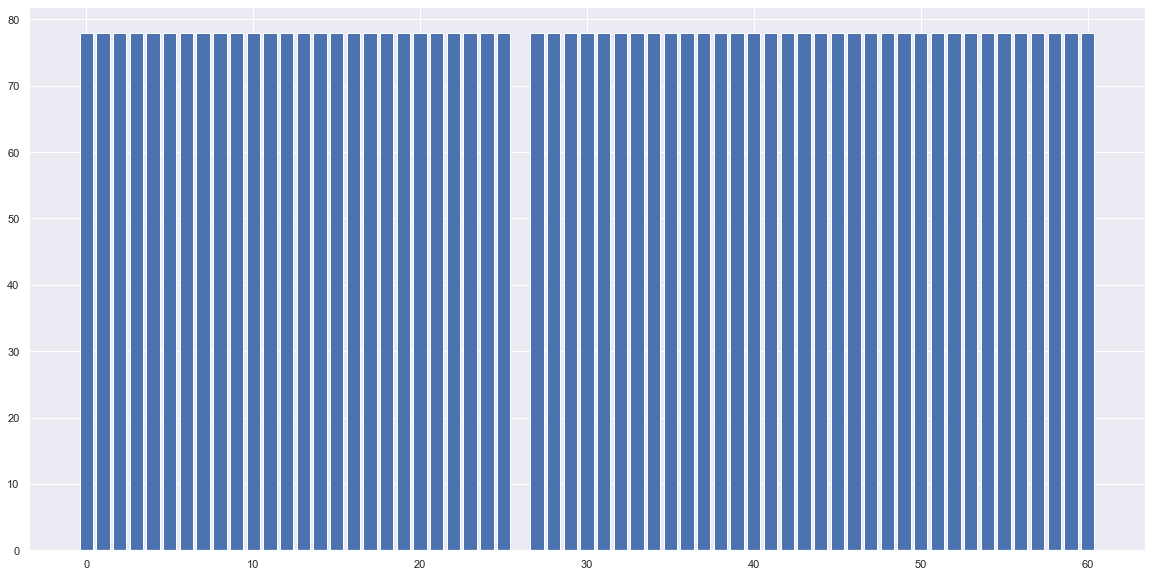

In [244]:
sns.set(rc={'figure.figsize':(20,10)})
plt.bar(y_over.value_counts().index,y_over.value_counts())
plt.savefig('random.png',dpi = 200)
plt.show()

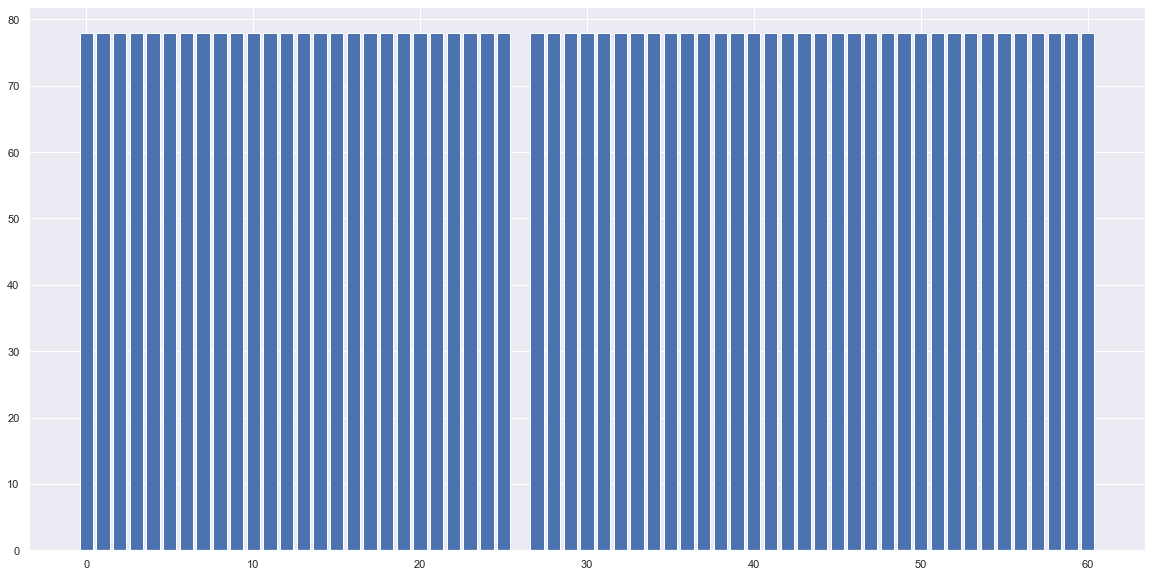

In [245]:
sns.set(rc={'figure.figsize':(20,10)})
plt.bar(y_train_over.value_counts().index,y_train_over.value_counts())
plt.savefig('smote.png',dpi = 200)
plt.show()

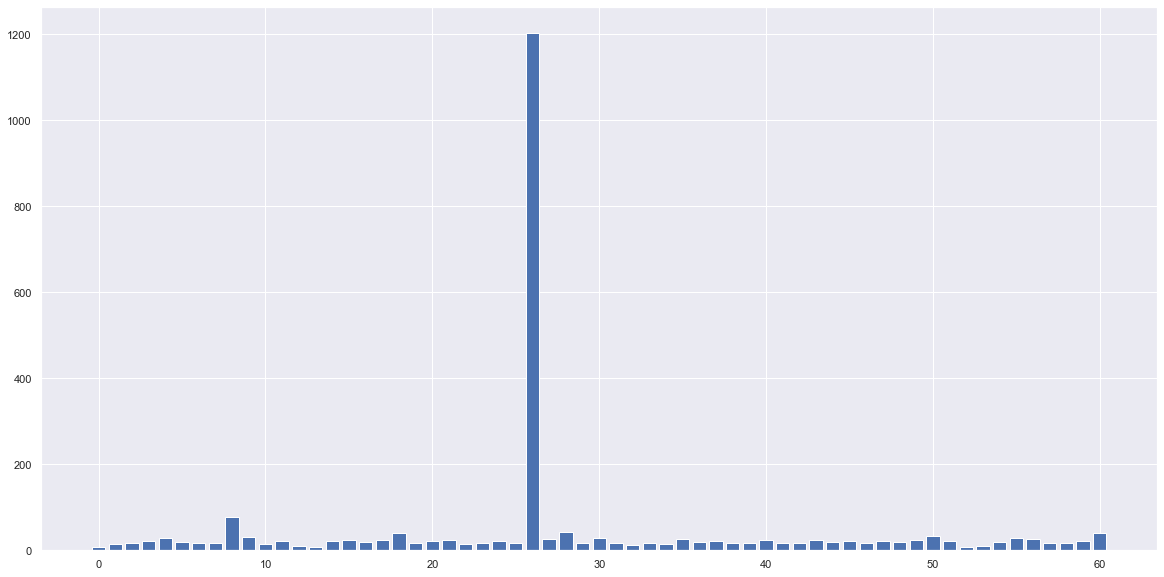

In [246]:
sns.set(rc={'figure.figsize':(20,10)})
plt.bar(y_train.value_counts().index,y_train.value_counts())
plt.savefig('raw.png',dpi = 200)
plt.show()

In [247]:
x_train1 = pd.concat([x_26,x_n26,x_over,x_train_over],axis=0)
y_train1 = pd.concat([y_26_label,y_label,y_over,y_train_over],axis=0)

In [248]:
x_train1=x_train1.drop(['label'],axis=1)

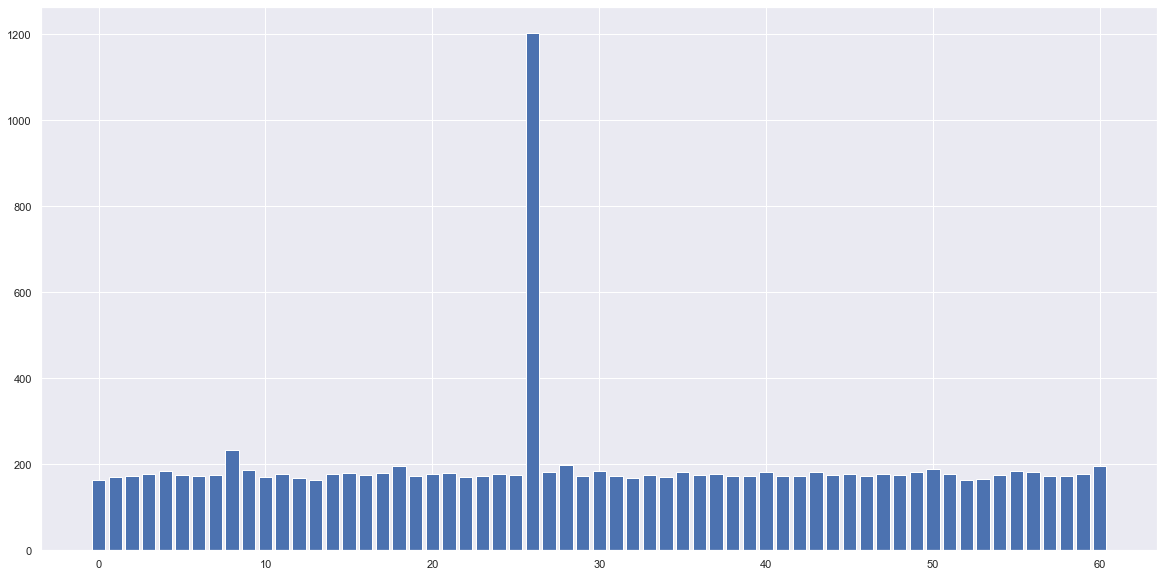

In [139]:
sns.set(rc={'figure.figsize':(20,10)})
plt.bar(y_train1.value_counts().index,y_train1.value_counts())
plt.savefig('y_train.png',dpi = 200)
plt.show()

In [249]:
x_train1, y_train1

(      acc_x_max  acc_x_min  acc_x_mean  acc_x_std  acc_x_median  \
 637    0.630341  -1.553586   -0.914852   0.322606     -0.963136   
 2495   1.229183  -1.267183   -0.062973   0.703703      0.097827   
 2758   1.696315  -4.202443   -0.700217   0.539947     -0.779052   
 1729   0.875578  -4.970905   -0.587154   0.408068     -0.510475   
 1766   0.065723  -1.656673   -0.667001   0.436975     -0.869594   
 ...         ...        ...         ...        ...           ...   
 4675  -0.706378  -1.094139   -0.886482   0.030309     -0.889694   
 4676  -0.238162  -0.853503   -0.461646   0.062641     -0.449477   
 4677  -0.767917  -1.029897   -0.899286   0.029491     -0.899976   
 4678  -0.352804  -0.916443   -0.771401   0.084383     -0.791462   
 4679  -0.485544  -1.706023   -1.034418   0.213386     -1.023600   
 
       acc_x_range_func  acc_x_iqr_func2  acc_x_iqr_func3  acc_x_iqr_func4  \
 637           2.183928        -0.260602        -0.065094        -0.522926   
 2495          2.496366   

In [250]:
from imblearn.under_sampling import RandomUnderSampler
random_under=RandomUnderSampler(sampling_strategy='majority')
X_ran_under_over, y_ran_under_over = random_under.fit_resample(x_train1, y_train1)

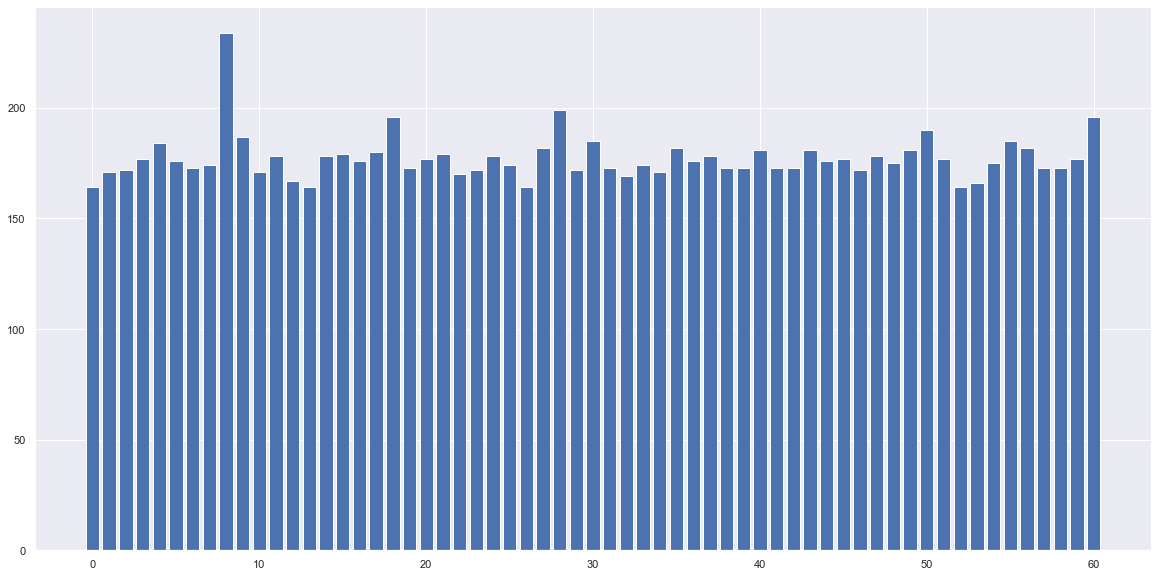

In [140]:
sns.set(rc={'figure.figsize':(20,10)})
plt.bar(y_ran_under_over.value_counts().index,y_ran_under_over.value_counts())
plt.savefig('y_over_under.png',dpi = 200)
plt.show()

In [251]:
cat_train_uo=CatBoostClassifier(random_state=20)
cat_train_uo.fit(X_ran_under_over,y_ran_under_over)

Learning rate set to 0.089345
0:	learn: 3.7453404	total: 1.17s	remaining: 19m 26s
1:	learn: 3.4729786	total: 2.47s	remaining: 20m 33s
2:	learn: 3.1698088	total: 4.07s	remaining: 22m 33s
3:	learn: 2.9954837	total: 5.47s	remaining: 22m 43s
4:	learn: 2.8624510	total: 6.64s	remaining: 22m
5:	learn: 2.6888688	total: 7.75s	remaining: 21m 23s
6:	learn: 2.5602867	total: 8.83s	remaining: 20m 52s
7:	learn: 2.4393236	total: 9.93s	remaining: 20m 30s
8:	learn: 2.2844037	total: 11.1s	remaining: 20m 22s
9:	learn: 2.1806854	total: 12.3s	remaining: 20m 15s
10:	learn: 2.0849882	total: 13.4s	remaining: 20m 4s
11:	learn: 1.9949714	total: 14.5s	remaining: 19m 53s
12:	learn: 1.9019367	total: 15.6s	remaining: 19m 45s
13:	learn: 1.8213751	total: 16.8s	remaining: 19m 44s
14:	learn: 1.7552202	total: 18s	remaining: 19m 42s
15:	learn: 1.6928757	total: 19.1s	remaining: 19m 36s
16:	learn: 1.6320872	total: 20.2s	remaining: 19m 30s
17:	learn: 1.5645338	total: 21.3s	remaining: 19m 24s
18:	learn: 1.5008543	total: 22.5s

153:	learn: 0.1459662	total: 2m 58s	remaining: 16m 22s
154:	learn: 0.1446512	total: 2m 59s	remaining: 16m 21s
155:	learn: 0.1438597	total: 3m 1s	remaining: 16m 19s
156:	learn: 0.1425207	total: 3m 2s	remaining: 16m 17s
157:	learn: 0.1408255	total: 3m 3s	remaining: 16m 16s
158:	learn: 0.1398342	total: 3m 4s	remaining: 16m 14s
159:	learn: 0.1391840	total: 3m 5s	remaining: 16m 13s
160:	learn: 0.1380412	total: 3m 6s	remaining: 16m 11s
161:	learn: 0.1364626	total: 3m 7s	remaining: 16m 10s
162:	learn: 0.1357961	total: 3m 8s	remaining: 16m 8s
163:	learn: 0.1342481	total: 3m 9s	remaining: 16m 7s
164:	learn: 0.1331543	total: 3m 10s	remaining: 16m 5s
165:	learn: 0.1322041	total: 3m 11s	remaining: 16m 3s
166:	learn: 0.1308972	total: 3m 12s	remaining: 16m 2s
167:	learn: 0.1303325	total: 3m 14s	remaining: 16m
168:	learn: 0.1293630	total: 3m 15s	remaining: 15m 59s
169:	learn: 0.1286962	total: 3m 16s	remaining: 15m 58s
170:	learn: 0.1280478	total: 3m 17s	remaining: 15m 56s
171:	learn: 0.1272352	total:

304:	learn: 0.0565788	total: 6m 6s	remaining: 13m 54s
305:	learn: 0.0563111	total: 6m 7s	remaining: 13m 53s
306:	learn: 0.0559966	total: 6m 8s	remaining: 13m 52s
307:	learn: 0.0557275	total: 6m 9s	remaining: 13m 51s
308:	learn: 0.0553840	total: 6m 11s	remaining: 13m 50s
309:	learn: 0.0551935	total: 6m 12s	remaining: 13m 49s
310:	learn: 0.0549807	total: 6m 13s	remaining: 13m 48s
311:	learn: 0.0547112	total: 6m 15s	remaining: 13m 47s
312:	learn: 0.0545108	total: 6m 16s	remaining: 13m 46s
313:	learn: 0.0541129	total: 6m 17s	remaining: 13m 45s
314:	learn: 0.0538941	total: 6m 18s	remaining: 13m 43s
315:	learn: 0.0536761	total: 6m 20s	remaining: 13m 42s
316:	learn: 0.0535077	total: 6m 21s	remaining: 13m 41s
317:	learn: 0.0531817	total: 6m 22s	remaining: 13m 40s
318:	learn: 0.0529836	total: 6m 23s	remaining: 13m 39s
319:	learn: 0.0527634	total: 6m 25s	remaining: 13m 38s
320:	learn: 0.0526326	total: 6m 26s	remaining: 13m 37s
321:	learn: 0.0523849	total: 6m 27s	remaining: 13m 36s
322:	learn: 0.

455:	learn: 0.0315777	total: 9m 15s	remaining: 11m 2s
456:	learn: 0.0314810	total: 9m 16s	remaining: 11m 1s
457:	learn: 0.0313198	total: 9m 17s	remaining: 11m
458:	learn: 0.0312008	total: 9m 18s	remaining: 10m 58s
459:	learn: 0.0310694	total: 9m 20s	remaining: 10m 57s
460:	learn: 0.0310446	total: 9m 21s	remaining: 10m 56s
461:	learn: 0.0309572	total: 9m 22s	remaining: 10m 54s
462:	learn: 0.0307920	total: 9m 23s	remaining: 10m 53s
463:	learn: 0.0307235	total: 9m 24s	remaining: 10m 52s
464:	learn: 0.0306081	total: 9m 25s	remaining: 10m 50s
465:	learn: 0.0305514	total: 9m 26s	remaining: 10m 49s
466:	learn: 0.0305226	total: 9m 28s	remaining: 10m 48s
467:	learn: 0.0304230	total: 9m 29s	remaining: 10m 47s
468:	learn: 0.0302292	total: 9m 30s	remaining: 10m 45s
469:	learn: 0.0301679	total: 9m 31s	remaining: 10m 44s
470:	learn: 0.0300682	total: 9m 32s	remaining: 10m 43s
471:	learn: 0.0299919	total: 9m 34s	remaining: 10m 42s
472:	learn: 0.0299179	total: 9m 35s	remaining: 10m 41s
473:	learn: 0.02

605:	learn: 0.0205809	total: 12m 24s	remaining: 8m 3s
606:	learn: 0.0205397	total: 12m 25s	remaining: 8m 2s
607:	learn: 0.0204765	total: 12m 26s	remaining: 8m 1s
608:	learn: 0.0204228	total: 12m 27s	remaining: 8m
609:	learn: 0.0203895	total: 12m 29s	remaining: 7m 58s
610:	learn: 0.0203423	total: 12m 30s	remaining: 7m 57s
611:	learn: 0.0202651	total: 12m 31s	remaining: 7m 56s
612:	learn: 0.0202115	total: 12m 32s	remaining: 7m 55s
613:	learn: 0.0201635	total: 12m 34s	remaining: 7m 54s
614:	learn: 0.0201252	total: 12m 35s	remaining: 7m 52s
615:	learn: 0.0200726	total: 12m 36s	remaining: 7m 51s
616:	learn: 0.0200417	total: 12m 37s	remaining: 7m 50s
617:	learn: 0.0199865	total: 12m 39s	remaining: 7m 49s
618:	learn: 0.0199383	total: 12m 40s	remaining: 7m 48s
619:	learn: 0.0199009	total: 12m 41s	remaining: 7m 46s
620:	learn: 0.0198682	total: 12m 42s	remaining: 7m 45s
621:	learn: 0.0197859	total: 12m 44s	remaining: 7m 44s
622:	learn: 0.0197139	total: 12m 45s	remaining: 7m 43s
623:	learn: 0.019

756:	learn: 0.0146090	total: 15m 31s	remaining: 4m 58s
757:	learn: 0.0145987	total: 15m 32s	remaining: 4m 57s
758:	learn: 0.0145640	total: 15m 33s	remaining: 4m 56s
759:	learn: 0.0145324	total: 15m 34s	remaining: 4m 55s
760:	learn: 0.0145106	total: 15m 35s	remaining: 4m 53s
761:	learn: 0.0144876	total: 15m 36s	remaining: 4m 52s
762:	learn: 0.0144694	total: 15m 38s	remaining: 4m 51s
763:	learn: 0.0144435	total: 15m 39s	remaining: 4m 50s
764:	learn: 0.0144165	total: 15m 40s	remaining: 4m 49s
765:	learn: 0.0143951	total: 15m 42s	remaining: 4m 47s
766:	learn: 0.0143611	total: 15m 43s	remaining: 4m 46s
767:	learn: 0.0143342	total: 15m 44s	remaining: 4m 45s
768:	learn: 0.0143179	total: 15m 45s	remaining: 4m 44s
769:	learn: 0.0142797	total: 15m 47s	remaining: 4m 42s
770:	learn: 0.0142556	total: 15m 48s	remaining: 4m 41s
771:	learn: 0.0142272	total: 15m 49s	remaining: 4m 40s
772:	learn: 0.0142020	total: 15m 50s	remaining: 4m 39s
773:	learn: 0.0141700	total: 15m 52s	remaining: 4m 37s
774:	learn

907:	learn: 0.0112049	total: 18m 39s	remaining: 1m 53s
908:	learn: 0.0111906	total: 18m 41s	remaining: 1m 52s
909:	learn: 0.0111737	total: 18m 42s	remaining: 1m 51s
910:	learn: 0.0111557	total: 18m 43s	remaining: 1m 49s
911:	learn: 0.0111395	total: 18m 45s	remaining: 1m 48s
912:	learn: 0.0111196	total: 18m 46s	remaining: 1m 47s
913:	learn: 0.0111020	total: 18m 47s	remaining: 1m 46s
914:	learn: 0.0110804	total: 18m 48s	remaining: 1m 44s
915:	learn: 0.0110538	total: 18m 50s	remaining: 1m 43s
916:	learn: 0.0110328	total: 18m 51s	remaining: 1m 42s
917:	learn: 0.0110086	total: 18m 52s	remaining: 1m 41s
918:	learn: 0.0109805	total: 18m 54s	remaining: 1m 39s
919:	learn: 0.0109664	total: 18m 55s	remaining: 1m 38s
920:	learn: 0.0109532	total: 18m 56s	remaining: 1m 37s
921:	learn: 0.0109299	total: 18m 57s	remaining: 1m 36s
922:	learn: 0.0109149	total: 18m 58s	remaining: 1m 35s
923:	learn: 0.0108954	total: 19m	remaining: 1m 33s
924:	learn: 0.0108741	total: 19m 1s	remaining: 1m 32s
925:	learn: 0.0

In [252]:
mypredictions_uo = cat_train_uo.predict(x_test)
print('test 정확도 : ',accuracy_score(y_test, mypredictions_uo))

test 정확도 :  0.7952


In [253]:
mypredictionst_uo = cat_train_uo.predict(X_ran_under_over)
print('train 정확도 : ',accuracy_score(y_ran_under_over, mypredictionst_uo))

train 정확도 :  1.0


In [255]:
predict_uo_de=cat_train_uo.predict_proba(test_preprocess)
submission_uo_de = sub.copy()
submission_uo_de.iloc[:,1:]=predict_uo_de
submission_uo_de.to_csv('submission_cat_uo_de_220402.csv', index=False)

In [256]:
submission_uo_de

,id,0,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,3125,0.000018,0.000033,0.000012,0.000113,1.525737e-04,0.000017,0.000319,0.000011,0.000037,...,0.003858,0.000050,0.000093,0.000040,0.000008,0.000029,0.000348,0.024660,0.000014,0.000419
1,3126,0.004512,0.005163,0.000044,0.001106,2.751840e-03,0.008308,0.000170,0.004455,0.000434,...,0.002817,0.000067,0.000856,0.000710,0.000115,0.001824,0.001902,0.000307,0.001510,0.000731
2,3127,0.013572,0.377549,0.000120,0.001113,1.243232e-03,0.004127,0.072258,0.020662,0.004053,...,0.000285,0.000133,0.000241,0.002057,0.000130,0.001091,0.000051,0.000821,0.002268,0.033036
3,3128,0.046788,0.000234,0.001537,0.000451,1.120583e-04,0.000101,0.000012,0.000320,0.000199,...,0.000362,0.000044,0.000187,0.000870,0.000115,0.000052,0.001582,0.000219,0.000012,0.017798
4,3129,0.019134,0.000210,0.000007,0.000270,4.028923e-03,0.000268,0.000009,0.000805,0.000242,...,0.000168,0.000003,0.000012,0.000007,0.000017,0.000033,0.004027,0.000032,0.000290,0.000184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0.015424,0.000100,0.000018,0.000147,8.950577e-01,0.000325,0.000013,0.000084,0.000114,...,0.000101,0.000008,0.000083,0.000009,0.000008,0.000014,0.000240,0.000100,0.000236,0.000737
778,3903,0.004963,0.000278,0.000015,0.000736,9.026247e-03,0.004494,0.000021,0.000145,0.000276,...,0.000363,0.000006,0.000212,0.000024,0.000041,0.000198,0.000395,0.000070,0.000367,0.000114
779,3904,0.000395,0.000014,0.000038,0.000084,1.923214e-04,0.000059,0.000006,0.000073,0.000315,...,0.000169,0.000005,0.000065,0.000010,0.000026,0.000009,0.002907,0.000038,0.000018,0.003583
780,3905,0.000006,0.000966,0.000010,0.000008,8.159235e-07,0.000005,0.001088,0.000066,0.000003,...,0.000009,0.000001,0.000011,0.000058,0.000012,0.000039,0.000005,0.000009,0.000003,0.000005


<BarContainer object of 61 artists>

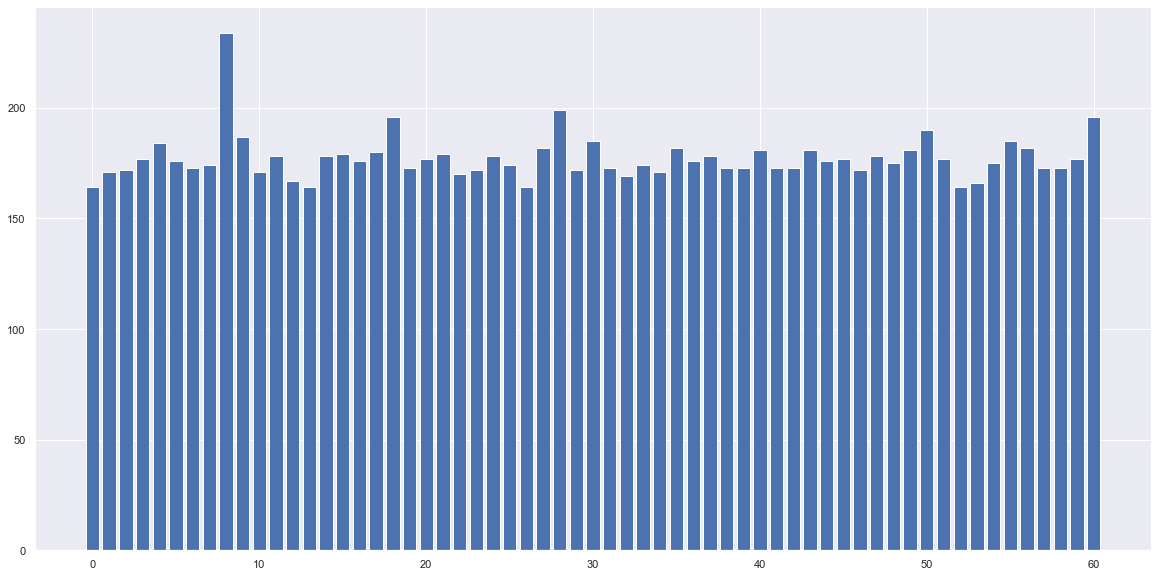

In [152]:
plt.bar(y_ran_under_over.value_counts().index,y_ran_under_over.value_counts())

In [153]:
predict_dep_t=cat_train.predict_proba(test_preprocess)
submission_dep_t = sub.copy()
submission_dep_t.iloc[:,1:]=predict_dep_t
submission_dep_t.to_csv('submission_cat_overunder_220402.csv', index=False)

In [154]:
submission_dep_t

,id,0,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,3125,0.000011,0.000022,1.662162e-06,3.168531e-05,3.648710e-05,2.755477e-06,0.000056,0.000005,7.621527e-06,...,4.640365e-03,5.436576e-05,2.666388e-05,0.000010,5.671734e-06,0.000042,6.302955e-04,2.736479e-02,5.988881e-07,8.661291e-05
1,3126,0.001595,0.000121,1.256571e-05,6.211364e-04,1.728409e-03,2.199968e-03,0.000029,0.000918,1.018178e-04,...,6.693876e-04,5.217259e-06,1.164877e-03,0.000399,1.131313e-04,0.000377,9.182163e-05,3.007553e-05,1.765700e-04,9.190650e-05
2,3127,0.027737,0.055249,7.842436e-05,2.720801e-04,1.259618e-03,3.431126e-04,0.047532,0.022513,1.098511e-02,...,4.973806e-05,9.495608e-05,2.333427e-04,0.004039,1.080686e-04,0.002032,8.834388e-05,6.910589e-04,1.540868e-02,1.337749e-02
3,3128,0.237299,0.000260,8.720475e-04,3.705984e-04,3.006184e-05,2.033255e-04,0.000014,0.000542,7.953123e-04,...,2.326445e-04,1.399342e-04,9.264823e-05,0.000244,2.136152e-04,0.000100,1.487471e-04,8.271824e-05,1.495110e-05,3.391726e-02
4,3129,0.009737,0.000025,2.519982e-05,1.876093e-03,3.408516e-03,7.899748e-04,0.000003,0.001745,8.105871e-05,...,3.289780e-04,3.164935e-06,2.656120e-05,0.000073,9.582123e-05,0.000067,3.018227e-03,2.036003e-05,1.957945e-04,3.081901e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0.001338,0.000042,3.083944e-06,2.988855e-05,9.502847e-01,5.162652e-04,0.000002,0.000029,8.773106e-05,...,2.608264e-05,4.644600e-06,1.556354e-05,0.000008,3.556206e-06,0.000007,6.628728e-05,3.794272e-05,1.372129e-04,2.499877e-04
778,3903,0.001980,0.000334,1.493334e-05,1.218985e-03,4.708638e-02,6.299039e-03,0.000014,0.000181,1.314399e-04,...,2.806117e-04,1.089383e-05,2.216420e-05,0.000055,6.447617e-05,0.000388,2.330153e-04,3.813804e-05,3.026437e-04,1.856314e-04
779,3904,0.000543,0.000006,8.503639e-05,1.319913e-04,9.409903e-05,4.482503e-05,0.000014,0.000151,9.403242e-04,...,5.519025e-04,4.688791e-06,1.222326e-04,0.000069,2.678521e-04,0.000018,7.278911e-04,1.610772e-05,1.018891e-05,3.043645e-02
780,3905,0.000001,0.000195,2.718877e-07,1.104438e-07,2.508198e-08,5.525377e-07,0.000034,0.000001,1.252702e-07,...,5.893630e-08,8.541497e-08,1.243840e-07,0.000001,7.118908e-07,0.000003,1.860849e-07,8.149113e-07,4.617256e-08,9.428411e-08


In [97]:
cat_train2=CatBoostClassifier(random_state=20,iterations=300,depth=3)
cat_train2.fit(X_ran_under_over,y_ran_under_over)

Learning rate set to 0.247116
0:	learn: 3.7754776	total: 165ms	remaining: 49.2s
1:	learn: 3.3107578	total: 336ms	remaining: 50.1s
2:	learn: 3.0762190	total: 489ms	remaining: 48.4s
3:	learn: 2.8295882	total: 678ms	remaining: 50.2s
4:	learn: 2.6245053	total: 900ms	remaining: 53.1s
5:	learn: 2.4123588	total: 1.17s	remaining: 57.1s
6:	learn: 2.2929006	total: 1.36s	remaining: 57s
7:	learn: 2.2054763	total: 1.55s	remaining: 56.7s
8:	learn: 2.1016816	total: 1.74s	remaining: 56.3s
9:	learn: 2.0027631	total: 1.93s	remaining: 55.9s
10:	learn: 1.9194350	total: 2.08s	remaining: 54.7s
11:	learn: 1.7794056	total: 2.27s	remaining: 54.5s
12:	learn: 1.7126382	total: 2.43s	remaining: 53.7s
13:	learn: 1.6553811	total: 2.59s	remaining: 52.9s
14:	learn: 1.5796076	total: 2.76s	remaining: 52.5s
15:	learn: 1.5293339	total: 2.93s	remaining: 52s
16:	learn: 1.4708123	total: 3.26s	remaining: 54.2s
17:	learn: 1.4063106	total: 3.47s	remaining: 54.4s
18:	learn: 1.3553825	total: 3.68s	remaining: 54.4s
19:	learn: 1.29

161:	learn: 0.1535001	total: 28s	remaining: 23.9s
162:	learn: 0.1519670	total: 28.2s	remaining: 23.7s
163:	learn: 0.1514603	total: 28.4s	remaining: 23.5s
164:	learn: 0.1499348	total: 28.5s	remaining: 23.4s
165:	learn: 0.1483276	total: 28.7s	remaining: 23.2s
166:	learn: 0.1469207	total: 28.9s	remaining: 23s
167:	learn: 0.1459183	total: 29.1s	remaining: 22.8s
168:	learn: 0.1449824	total: 29.2s	remaining: 22.7s
169:	learn: 0.1438869	total: 29.4s	remaining: 22.5s
170:	learn: 0.1423669	total: 29.6s	remaining: 22.3s
171:	learn: 0.1417559	total: 29.8s	remaining: 22.1s
172:	learn: 0.1411448	total: 29.9s	remaining: 22s
173:	learn: 0.1403560	total: 30.1s	remaining: 21.8s
174:	learn: 0.1393350	total: 30.2s	remaining: 21.6s
175:	learn: 0.1387466	total: 30.4s	remaining: 21.4s
176:	learn: 0.1372597	total: 30.6s	remaining: 21.3s
177:	learn: 0.1364081	total: 30.7s	remaining: 21.1s
178:	learn: 0.1354287	total: 30.9s	remaining: 20.9s
179:	learn: 0.1345743	total: 31.1s	remaining: 20.7s
180:	learn: 0.1338

In [98]:
mypredictions2 = cat_train2.predict(x_test)
print('test 정확도 : ',accuracy_score(y_test, mypredictions2))

test 정확도 :  0.7408


In [99]:
mypredictionst2 = cat_train2.predict(X_ran_under_over)
print('train 정확도 : ',accuracy_score(y_ran_under_over, mypredictionst2))

train 정확도 :  0.999445471349353


In [116]:
cat_train3=CatBoostClassifier(random_state=20,iterations=30,depth=5)
cat_train3.fit(X_ran_under_over,y_ran_under_over)

Learning rate set to 0.5
0:	learn: 3.2251258	total: 767ms	remaining: 22.2s
1:	learn: 2.4629776	total: 1.52s	remaining: 21.3s
2:	learn: 2.0268730	total: 2.4s	remaining: 21.6s
3:	learn: 1.7281244	total: 3.17s	remaining: 20.6s
4:	learn: 1.4557949	total: 3.92s	remaining: 19.6s
5:	learn: 1.2866603	total: 4.66s	remaining: 18.6s
6:	learn: 1.1733975	total: 5.42s	remaining: 17.8s
7:	learn: 1.0713233	total: 6.18s	remaining: 17s
8:	learn: 0.9505005	total: 6.92s	remaining: 16.1s
9:	learn: 0.8590505	total: 7.67s	remaining: 15.3s
10:	learn: 0.7452216	total: 8.49s	remaining: 14.7s
11:	learn: 0.6777991	total: 9.26s	remaining: 13.9s
12:	learn: 0.6251302	total: 10.1s	remaining: 13.2s
13:	learn: 0.5864951	total: 10.9s	remaining: 12.5s
14:	learn: 0.5286666	total: 11.8s	remaining: 11.8s
15:	learn: 0.4959494	total: 12.6s	remaining: 11s
16:	learn: 0.4771068	total: 13.3s	remaining: 10.2s
17:	learn: 0.4397694	total: 14.1s	remaining: 9.39s
18:	learn: 0.4134918	total: 14.9s	remaining: 8.6s
19:	learn: 0.3941428	t

In [117]:
mypredictions3 = cat_train3.predict(x_test)
print('test 정확도 : ',accuracy_score(y_test, mypredictions3))

test 정확도 :  0.5376


In [118]:
mypredictionst3 = cat_train3.predict(X_ran_under_over)
print('train 정확도 : ',accuracy_score(y_ran_under_over, mypredictionst3))

train 정확도 :  0.9740295748613679


In [110]:
cat_train4=CatBoostClassifier(random_state=20,iterations=229,depth=5)
cat_train4.fit(X_ran_under_over,y_ran_under_over)

Learning rate set to 0.310462
0:	learn: 3.3358256	total: 826ms	remaining: 3m 8s
1:	learn: 2.6735175	total: 1.77s	remaining: 3m 20s
2:	learn: 2.3337707	total: 2.66s	remaining: 3m 20s
3:	learn: 2.0530159	total: 3.53s	remaining: 3m 18s
4:	learn: 1.7651754	total: 4.35s	remaining: 3m 14s
5:	learn: 1.5952821	total: 5.16s	remaining: 3m 11s
6:	learn: 1.4812159	total: 5.91s	remaining: 3m 7s
7:	learn: 1.3881251	total: 6.68s	remaining: 3m 4s
8:	learn: 1.2772331	total: 7.43s	remaining: 3m 1s
9:	learn: 1.1863619	total: 8.15s	remaining: 2m 58s
10:	learn: 1.0852801	total: 8.87s	remaining: 2m 55s
11:	learn: 1.0256543	total: 9.61s	remaining: 2m 53s
12:	learn: 0.9666084	total: 10.3s	remaining: 2m 51s
13:	learn: 0.8992278	total: 11.1s	remaining: 2m 50s
14:	learn: 0.8398449	total: 11.8s	remaining: 2m 48s
15:	learn: 0.7766762	total: 12.6s	remaining: 2m 47s
16:	learn: 0.7335706	total: 13.3s	remaining: 2m 45s
17:	learn: 0.6774771	total: 14s	remaining: 2m 44s
18:	learn: 0.6413414	total: 14.7s	remaining: 2m 42

156:	learn: 0.0369925	total: 1m 55s	remaining: 53.2s
157:	learn: 0.0363909	total: 1m 56s	remaining: 52.4s
158:	learn: 0.0359439	total: 1m 57s	remaining: 51.7s
159:	learn: 0.0357083	total: 1m 58s	remaining: 51s
160:	learn: 0.0355064	total: 1m 58s	remaining: 50.2s
161:	learn: 0.0351102	total: 1m 59s	remaining: 49.5s
162:	learn: 0.0348519	total: 2m	remaining: 48.7s
163:	learn: 0.0345541	total: 2m 1s	remaining: 48s
164:	learn: 0.0342185	total: 2m 1s	remaining: 47.3s
165:	learn: 0.0338790	total: 2m 2s	remaining: 46.5s
166:	learn: 0.0335109	total: 2m 3s	remaining: 45.8s
167:	learn: 0.0332616	total: 2m 4s	remaining: 45s
168:	learn: 0.0328185	total: 2m 4s	remaining: 44.3s
169:	learn: 0.0323686	total: 2m 5s	remaining: 43.6s
170:	learn: 0.0321443	total: 2m 6s	remaining: 42.8s
171:	learn: 0.0317848	total: 2m 6s	remaining: 42.1s
172:	learn: 0.0313329	total: 2m 7s	remaining: 41.4s
173:	learn: 0.0309770	total: 2m 8s	remaining: 40.6s
174:	learn: 0.0306268	total: 2m 9s	remaining: 39.9s
175:	learn: 0.0

In [111]:
mypredictions4 = cat_train4.predict(x_test)
print('test 정확도 : ',accuracy_score(y_test, mypredictions4))

test 정확도 :  0.7408


In [112]:
mypredictionst4 = cat_train4.predict(X_ran_under_over)
print('train 정확도 : ',accuracy_score(y_ran_under_over, mypredictionst4))

train 정확도 :  1.0


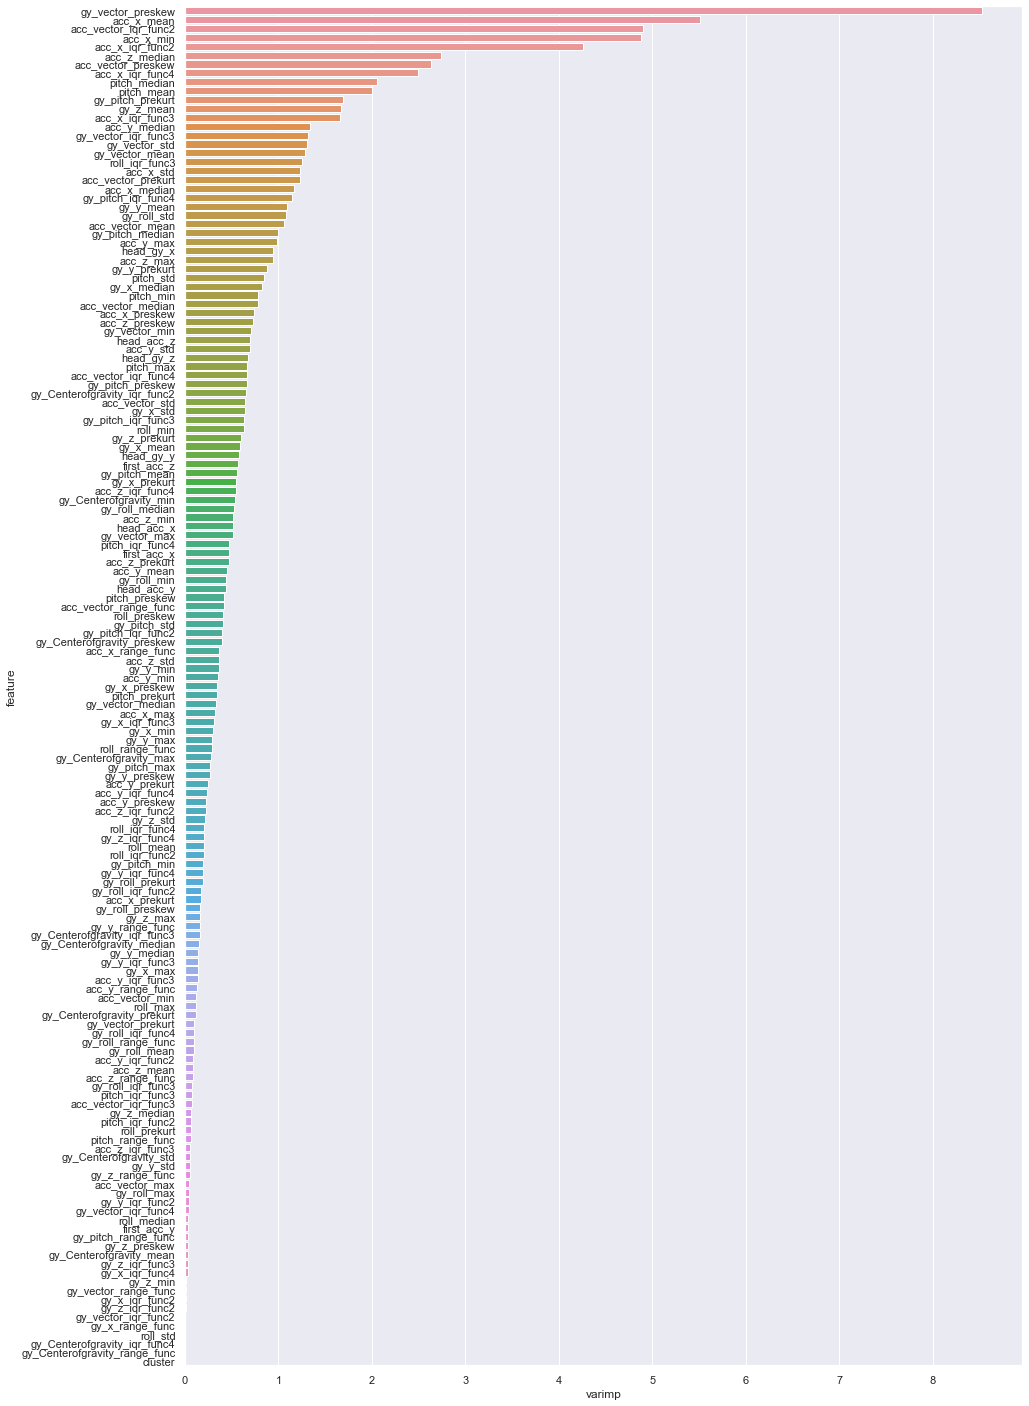

In [127]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,25)})
cat_feature_imp = pd.DataFrame([cat_train4.feature_names_ , cat_train4.feature_importances_]).T
cat_feature_imp.columns = ["feature","varimp"]
cat_feature_imp = cat_feature_imp.sort_values(by="varimp", ascending = False)
sns.barplot(y="feature", x="varimp",data = cat_feature_imp)
plt.savefig('cat229_5_feature2.png',dpi = 200)
plt.show()

In [ ]:
#label별로 분리한 train test set
model_cb=CatBoostClassifier()
model_cb.fit(x_label_split1,y_label_split1)
mypredictions = model_cb.predict(x_label_split2)
print('train 정확도 : ',accuracy_score(y_label_split1, model_cb.predict(x_label_split1)))
print('test 정확도 : ',accuracy_score(y_label_split2, mypredictions))

In [ ]:
model_cb_fin=CatBoostClassifier()
model_cb_fin.fit(train_preprocess, train_labels['label'])
predict_cb=model_cb_fin.predict_proba(test_preprocess)

In [ ]:
submission_cb = sub.copy()
submission_cb.iloc[:,1:]=predict_cb
submission_cb.to_csv('submission_cat_220328.csv', index=False)
submission_cb

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,25)})
cat_feature_imp = pd.DataFrame([model_cb.feature_names_ , model_cb.feature_importances_]).T
cat_feature_imp.columns = ["feature","varimp"]
cat_feature_imp = cat_feature_imp.sort_values(by="varimp", ascending = False)
sns.barplot(y="feature", x="varimp",data = cat_feature_imp)
plt.show()

In [ ]:
sns.set(rc={'figure.figsize':(10,25)})
cat_feature_imp = pd.DataFrame([model_cb_fin.feature_names_ , model_cb_fin.feature_importances_]).T
cat_feature_imp.columns = ["feature","varimp"]
cat_feature_imp = cat_feature_imp.sort_values(by="varimp", ascending = False)
sns.barplot(y="feature", x="varimp",data = cat_feature_imp)
plt.show()

In [121]:
from sklearn.metrics import accuracy_score
from bayes_opt import BayesianOptimization

In [147]:
cb_parameter_bounds = {'depth' : (3,10),
                      'iterations' : (50,1000),
                      }

def cb_bo(depth, iterations):
    bo_params = {
        'depth' : int(round(depth)),
        'iterations' : int(round(iterations)),    
    }
    
    cat_train_BO = CatBoostClassifier(**bo_params)

    cat_train_BO.fit(X_ran_under_over,y_ran_under_over)
    score = accuracy_score(y_test, cat_train_BO.predict(x_test))
    return score

In [148]:
BO_rf = BayesianOptimization(f = cb_bo, pbounds = cb_parameter_bounds,random_state = 0)

# Bayesian Optimization을 실행해보세요
BO_rf.maximize(init_points = 5, n_iter = 10)

|   iter    |  target   |   depth   | iterat... |
-------------------------------------------------
Learning rate set to 0.116698


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 3.7035104	total: 2.4s	remaining: 29m 5s
1:	learn: 3.2050303	total: 4.85s	remaining: 29m 22s
2:	learn: 2.9135711	total: 7.02s	remaining: 28m 18s
3:	learn: 2.6283279	total: 9.08s	remaining: 27m 26s
4:	learn: 2.4005776	total: 11.2s	remaining: 27m
5:	learn: 2.1971625	total: 13.3s	remaining: 26m 43s
6:	learn: 2.0594839	total: 15.4s	remaining: 26m 24s
7:	learn: 1.9258778	total: 17.5s	remaining: 26m 14s
8:	learn: 1.7908689	total: 19.6s	remaining: 26m 7s
9:	learn: 1.6783227	total: 22.1s	remaining: 26m 29s
10:	learn: 1.5756569	total: 24.4s	remaining: 26m 34s
11:	learn: 1.4723969	total: 26.7s	remaining: 26m 33s
12:	learn: 1.3837473	total: 28.9s	remaining: 26m 31s
13:	learn: 1.3101387	total: 31.3s	remaining: 26m 37s
14:	learn: 1.2385001	total: 33.8s	remaining: 26m 50s
15:	learn: 1.1747781	total: 36.2s	remaining: 26m 53s
16:	learn: 1.1227627	total: 38.6s	remaining: 26m 55s
17:	learn: 1.0614536	total: 41.1s	remaining: 27m 5s
18:	learn: 1.0183704	total: 43.9s	remaining: 27m 19s
19:	learn: 

153:	learn: 0.0683605	total: 6m 14s	remaining: 23m 19s
154:	learn: 0.0676927	total: 6m 17s	remaining: 23m 17s
155:	learn: 0.0669771	total: 6m 19s	remaining: 23m 13s
156:	learn: 0.0662502	total: 6m 22s	remaining: 23m 12s
157:	learn: 0.0657109	total: 6m 24s	remaining: 23m 10s
158:	learn: 0.0650571	total: 6m 27s	remaining: 23m 7s
159:	learn: 0.0643403	total: 6m 29s	remaining: 23m 5s
160:	learn: 0.0637718	total: 6m 32s	remaining: 23m 3s
161:	learn: 0.0632669	total: 6m 34s	remaining: 23m
162:	learn: 0.0625955	total: 6m 36s	remaining: 22m 57s
163:	learn: 0.0618611	total: 6m 39s	remaining: 22m 55s
164:	learn: 0.0614096	total: 6m 41s	remaining: 22m 53s
165:	learn: 0.0606110	total: 6m 44s	remaining: 22m 51s
166:	learn: 0.0601084	total: 6m 47s	remaining: 22m 50s
167:	learn: 0.0596907	total: 6m 49s	remaining: 22m 48s
168:	learn: 0.0590530	total: 6m 52s	remaining: 22m 45s
169:	learn: 0.0585836	total: 6m 54s	remaining: 22m 43s
170:	learn: 0.0581700	total: 6m 57s	remaining: 22m 41s
171:	learn: 0.057

303:	learn: 0.0259540	total: 12m 26s	remaining: 17m 24s
304:	learn: 0.0258460	total: 12m 29s	remaining: 17m 21s
305:	learn: 0.0257054	total: 12m 31s	remaining: 17m 18s
306:	learn: 0.0256034	total: 12m 33s	remaining: 17m 16s
307:	learn: 0.0254445	total: 12m 36s	remaining: 17m 13s
308:	learn: 0.0253227	total: 12m 38s	remaining: 17m 11s
309:	learn: 0.0252158	total: 12m 41s	remaining: 17m 9s
310:	learn: 0.0251435	total: 12m 44s	remaining: 17m 7s
311:	learn: 0.0250362	total: 12m 46s	remaining: 17m 4s
312:	learn: 0.0249041	total: 12m 49s	remaining: 17m 2s
313:	learn: 0.0248099	total: 12m 51s	remaining: 17m
314:	learn: 0.0246646	total: 12m 54s	remaining: 16m 57s
315:	learn: 0.0245092	total: 12m 56s	remaining: 16m 54s
316:	learn: 0.0243662	total: 12m 58s	remaining: 16m 52s
317:	learn: 0.0242315	total: 13m 1s	remaining: 16m 50s
318:	learn: 0.0241251	total: 13m 4s	remaining: 16m 47s
319:	learn: 0.0240083	total: 13m 6s	remaining: 16m 45s
320:	learn: 0.0238839	total: 13m 8s	remaining: 16m 42s
321:

451:	learn: 0.0145002	total: 18m 26s	remaining: 11m 18s
452:	learn: 0.0144631	total: 18m 29s	remaining: 11m 15s
453:	learn: 0.0144268	total: 18m 31s	remaining: 11m 13s
454:	learn: 0.0143746	total: 18m 33s	remaining: 11m 10s
455:	learn: 0.0143314	total: 18m 35s	remaining: 11m 8s
456:	learn: 0.0143030	total: 18m 38s	remaining: 11m 5s
457:	learn: 0.0142792	total: 18m 40s	remaining: 11m 3s
458:	learn: 0.0142257	total: 18m 43s	remaining: 11m 1s
459:	learn: 0.0141946	total: 18m 46s	remaining: 10m 58s
460:	learn: 0.0141430	total: 18m 48s	remaining: 10m 56s
461:	learn: 0.0140806	total: 18m 50s	remaining: 10m 53s
462:	learn: 0.0140232	total: 18m 53s	remaining: 10m 51s
463:	learn: 0.0139804	total: 18m 55s	remaining: 10m 48s
464:	learn: 0.0139557	total: 18m 58s	remaining: 10m 46s
465:	learn: 0.0139114	total: 19m 1s	remaining: 10m 44s
466:	learn: 0.0138624	total: 19m 4s	remaining: 10m 42s
467:	learn: 0.0138273	total: 19m 7s	remaining: 10m 40s
468:	learn: 0.0137761	total: 19m 9s	remaining: 10m 37s


601:	learn: 0.0097624	total: 24m 24s	remaining: 5m 8s
602:	learn: 0.0097426	total: 24m 26s	remaining: 5m 6s
603:	learn: 0.0097258	total: 24m 29s	remaining: 5m 4s
604:	learn: 0.0097086	total: 24m 31s	remaining: 5m 1s
605:	learn: 0.0096917	total: 24m 33s	remaining: 4m 59s
606:	learn: 0.0096719	total: 24m 36s	remaining: 4m 56s
607:	learn: 0.0096420	total: 24m 38s	remaining: 4m 54s
608:	learn: 0.0096182	total: 24m 41s	remaining: 4m 51s
609:	learn: 0.0095998	total: 24m 43s	remaining: 4m 49s
610:	learn: 0.0095752	total: 24m 46s	remaining: 4m 47s
611:	learn: 0.0095612	total: 24m 49s	remaining: 4m 44s
612:	learn: 0.0095406	total: 24m 51s	remaining: 4m 42s
613:	learn: 0.0095192	total: 24m 53s	remaining: 4m 39s
614:	learn: 0.0095045	total: 24m 56s	remaining: 4m 37s
615:	learn: 0.0094815	total: 24m 58s	remaining: 4m 34s
616:	learn: 0.0094666	total: 25m 1s	remaining: 4m 32s
617:	learn: 0.0094488	total: 25m 3s	remaining: 4m 30s
618:	learn: 0.0094275	total: 25m 5s	remaining: 4m 27s
619:	learn: 0.009

22:	learn: 0.7228656	total: 49.6s	remaining: 19m 36s
23:	learn: 0.6937967	total: 51.8s	remaining: 19m 33s
24:	learn: 0.6650260	total: 54.1s	remaining: 19m 34s
25:	learn: 0.6345013	total: 56.7s	remaining: 19m 41s
26:	learn: 0.6047583	total: 59s	remaining: 19m 43s
27:	learn: 0.5773145	total: 1m 1s	remaining: 19m 43s
28:	learn: 0.5494117	total: 1m 3s	remaining: 19m 42s
29:	learn: 0.5288562	total: 1m 5s	remaining: 19m 43s
30:	learn: 0.5042231	total: 1m 8s	remaining: 19m 44s
31:	learn: 0.4801832	total: 1m 11s	remaining: 19m 49s
32:	learn: 0.4582092	total: 1m 13s	remaining: 19m 55s
33:	learn: 0.4423655	total: 1m 16s	remaining: 19m 59s
34:	learn: 0.4286224	total: 1m 18s	remaining: 19m 58s
35:	learn: 0.4131426	total: 1m 21s	remaining: 19m 59s
36:	learn: 0.3963694	total: 1m 23s	remaining: 19m 58s
37:	learn: 0.3815808	total: 1m 25s	remaining: 19m 57s
38:	learn: 0.3672846	total: 1m 28s	remaining: 19m 55s
39:	learn: 0.3529407	total: 1m 30s	remaining: 19m 54s
40:	learn: 0.3434161	total: 1m 32s	rema

174:	learn: 0.0429881	total: 6m 48s	remaining: 15m 17s
175:	learn: 0.0427312	total: 6m 50s	remaining: 15m 14s
176:	learn: 0.0424626	total: 6m 52s	remaining: 15m 11s
177:	learn: 0.0420875	total: 6m 54s	remaining: 15m 8s
178:	learn: 0.0417192	total: 6m 57s	remaining: 15m 7s
179:	learn: 0.0414827	total: 6m 59s	remaining: 15m 4s
180:	learn: 0.0410647	total: 7m 1s	remaining: 15m 2s
181:	learn: 0.0407979	total: 7m 4s	remaining: 14m 59s
182:	learn: 0.0404001	total: 7m 6s	remaining: 14m 57s
183:	learn: 0.0400408	total: 7m 8s	remaining: 14m 54s
184:	learn: 0.0397689	total: 7m 10s	remaining: 14m 52s
185:	learn: 0.0394122	total: 7m 13s	remaining: 14m 49s
186:	learn: 0.0391492	total: 7m 15s	remaining: 14m 47s
187:	learn: 0.0388862	total: 7m 17s	remaining: 14m 45s
188:	learn: 0.0385680	total: 7m 20s	remaining: 14m 43s
189:	learn: 0.0383125	total: 7m 22s	remaining: 14m 40s
190:	learn: 0.0379696	total: 7m 25s	remaining: 14m 38s
191:	learn: 0.0377715	total: 7m 27s	remaining: 14m 36s
192:	learn: 0.0375

324:	learn: 0.0181400	total: 12m 31s	remaining: 9m 22s
325:	learn: 0.0180073	total: 12m 33s	remaining: 9m 19s
326:	learn: 0.0179207	total: 12m 36s	remaining: 9m 17s
327:	learn: 0.0178409	total: 12m 38s	remaining: 9m 14s
328:	learn: 0.0177537	total: 12m 40s	remaining: 9m 12s
329:	learn: 0.0176542	total: 12m 42s	remaining: 9m 9s
330:	learn: 0.0176109	total: 12m 44s	remaining: 9m 7s
331:	learn: 0.0175580	total: 12m 46s	remaining: 9m 4s
332:	learn: 0.0174849	total: 12m 48s	remaining: 9m 2s
333:	learn: 0.0173814	total: 12m 50s	remaining: 9m
334:	learn: 0.0172928	total: 12m 53s	remaining: 8m 57s
335:	learn: 0.0172276	total: 12m 55s	remaining: 8m 55s
336:	learn: 0.0171370	total: 12m 57s	remaining: 8m 53s
337:	learn: 0.0170539	total: 12m 59s	remaining: 8m 50s
338:	learn: 0.0169985	total: 13m 2s	remaining: 8m 48s
339:	learn: 0.0169394	total: 13m 4s	remaining: 8m 45s
340:	learn: 0.0168336	total: 13m 6s	remaining: 8m 43s
341:	learn: 0.0167759	total: 13m 8s	remaining: 8m 41s
342:	learn: 0.0167112	

KeyboardInterrupt: 

In [ ]:
model_BO_rf_tuend.fit(train_preprocess,train_labels['label'])

depth별로

# randomforest

model_rf=RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0)
model_rf.fit(x1,y1_1)

print('train 정확도 : ',model_rf.score(x1,y1_1))
print('test 정확도 : ',model_rf.score(x2,y2_1))

In [ ]:
print(x_label_split1.shape)
print(x_label_split2.shape)
print(y_label_split1.shape)
print(y_label_split2.shape)

GridSearch

BayesianOptimization

In [ ]:
from sklearn.metrics import accuracy_score
from bayes_opt import BayesianOptimization


cb_parameter_bounds = {'depth' : (3,10),
                      'iteration' : (50,300),
                      }

def cb_bo(depth,iteration):
    cb_params = {
        'depth' : int(round(depth)),
        'iteration' : int(round(depth)),
    }
    
    model_BO_cb = CatBoostClassifier(**cb_params)

    model_BO_cb.fit(x,y)
    score = accuracy_score(y_valid, model_BO_cb.predict(x_valid))
    return score

BO_rf = BayesianOptimization(f = cb_bo, pbounds = cb_parameter_bounds,random_state = 0)

# Bayesian Optimization을 실행해보세요
BO_rf.maximize(init_points = 10, n_iter = 20)


# 하이퍼파라미터의 결과값을 불러와 "max_params"라는 변수에 저장해보세요

max_params = BO_rf.max['params']

max_params['depth'] = int(max_params['depth'])
max_params['iteration'] = int(max_params['iteration'])
print(max_params)

# Bayesian Optimization의 결과를 "BO_tuend_rf"라는 변수에 저장해보세요

model_BO_cb_tuend = CatBoostClassifier(**max_params)

In [ ]:
CatBoostClassifier

In [ ]:
from sklearn.metrics import accuracy_score
from bayes_opt import BayesianOptimization

In [ ]:
rf_parameter_bounds = {'n_estimators' : (50,300),
                      'max_depth' : (5,50),
                       'min_samples_leaf' : (4,10),
                      'min_samples_split' : (4,10),
                      }

def rf_bo(max_depth, n_estimators,min_samples_leaf,min_samples_split):
    rf_params = {
        'max_depth' : int(round(max_depth)),
        'n_estimators' : int(round(n_estimators)),      
        'min_samples_leaf' : int(round(min_samples_leaf)),
        'min_samples_split' : int(round(min_samples_split)),
    }
    
    model_BO_rf = RandomForestClassifier(**rf_params)

    model_BO_rf.fit(x_label_split1,y_label_split1)
    score = accuracy_score(y_label_split2, model_BO_rf.predict(x_label_split2))
    return score

In [ ]:
BO_rf = BayesianOptimization(f = rf_bo, pbounds = rf_parameter_bounds,random_state = 0)

# Bayesian Optimization을 실행해보세요
BO_rf.maximize(init_points = 10, n_iter = 20)

In [ ]:

# 하이퍼파라미터의 결과값을 불러와 "max_params"라는 변수에 저장해보세요

max_params = BO_rf.max['params']

max_params['max_depth'] = int(max_params['max_depth'])
max_params['min_samples_leaf'] = int(max_params['min_samples_leaf'])
max_params['min_samples_split'] = int(max_params['min_samples_split'])
max_params['n_estimators'] = int(max_params['n_estimators'])
print(max_params)

# Bayesian Optimization의 결과를 "BO_tuend_rf"라는 변수에 저장해보세요

model_BO_rf_tuend = RandomForestClassifier(**max_params)

In [ ]:
model_BO_rf_tuend.fit(train_preprocess,train_labels['label'])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = model_BO_rf_tuend.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = train_preprocess.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,10))
plt.title('Top 20 Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [ ]:
model_BO_rf_tuend.fit(x_label_split1prediction2,y_label_split1)

In [ ]:
print("train score : ",accuracy_score(model_BO_rf_tuend.predict(x_label_split1[ftr_top20.index]),y_label_split1))
print("test score : ",accuracy_score(model_BO_rf_tuend.predict(x_label_split2[ftr_top20.index]),y_label_split2))

In [ ]:
BO_pred = model_BO_rf_tuend.predict(test_preprocess[ftr_top20.index])
BO_pred_hot = np_utils.to_categorical(BO_pred)
submission_BO_rf = sub.copy()
submission_BO_rf.iloc[:,1:]=BO_pred_hot
submission_BO_rf.to_csv('submission_BO_rf_220328.csv', index=False)

In [ ]:
submission_BO_rf.to_csv('submission_BO_rf_220325.csv', index=False)

# CNN

In [ ]:
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization, Conv1D, MaxPooling1D, Dropout, Flatten, Activation
from sklearn.model_selection import KFold, StratifiedKFold
from keras.utils import np_utils

In [ ]:
y = train_labels['label']

In [ ]:
print(train_arr_3d.shape)
print(test_arr_3d.shape)
print(y.shape)

In [ ]:
prediction=0
folds=10
repeats=2
epochsize=30
drop=0.5
skf = StratifiedKFold(n_splits=folds)
iter_num = 0

for k in range(repeats):
    for train_ind, test_ind in skf.split(train_arr_3d, y):
        
        iter_num += 1
        print(f"교차검증 : {iter_num}")
        
        model_cnn = Sequential()
        model_cnn.add(Conv1D (kernel_size=60, filters=256, strides=3, padding='valid',
                        kernel_initializer='he_uniform', input_shape=[600,13],
                        activation='relu'))
        model_cnn.add(MaxPooling1D(1, padding = 'valid'))

        model_cnn.add(Conv1D(kernel_size=60, filters=128, activation='relu'))
        model_cnn.add(MaxPooling1D(1, padding = 'valid'))

        model_cnn.add(Conv1D(kernel_size=60, filters=64, activation='relu'))
        model_cnn.add(MaxPooling1D(1, padding = 'valid'))

        model_cnn.add(BatchNormalization())

        model_cnn.add(Dropout(drop))
        model_cnn.add(Flatten())
        model_cnn.add(Dense(1024, activation='relu'))
        model_cnn.add(BatchNormalization())

        model_cnn.add(Dropout(drop))
        model_cnn.add(Dense(1024, activation='relu'))
        model_cnn.add(BatchNormalization())

        model_cnn.add(Dropout(drop))
        model_cnn.add(Dense(1024, activation='relu'))
        model_cnn.add(BatchNormalization())


        model_cnn.add(Dropout(drop))
        model_cnn.add(Dense(61))
        model_cnn.add(Activation('softmax'))

        adam = tf.keras.optimizers.Adam(lr=0.0001)

        model_cnn.compile(loss='categorical_crossentropy',
                      optimizer=adam,
                      metrics=['accuracy'])
        y_skf_hot = np_utils.to_categorical(y) # 3 -> [0,0,0,1,0, ..]
        
        model_cnn.fit(train_arr_3d[train_ind], y_skf_hot[train_ind], epochs=epochsize, batch_size=256,
                  validation_data=(train_arr_3d[test_ind], y_skf_hot[test_ind]))

        prediction += (model_cnn.predict(test_arr_3d)/(folds*repeats))

In [ ]:
submission_cnn = sub.copy()
submission_cnn.iloc[:,1:]=prediction
submission_cnn.to_csv('submission_cnn_220328.csv', index=False)

# 오버샘플링 CNN

In [ ]:
import random
from tqdm import tqdm_notebook

In [ ]:
train_labels['label'].value_counts()

In [ ]:
y_label = list(set(train_labels[train_labels['label']!=26]['label']))

In [ ]:
y_non_exer_non_id = []
for i in y_label:  
    y_non_exer_non_id += list(train_labels[train_labels['label'] == i]['id'])

In [ ]:
new_train = train.copy()
new_label = train_labels.copy()

for i in tqdm_notebook(y_non_exer_non_id, desc="tqdm example", mininterval=0.01):
    temp_x=train[train["id"]==i]
    temp_y=train_labels[train_labels["id"]==i]
    #num_count = train_labels['label'].value_counts()[train_labels[train_labels["id"]==0]['label']]
    for j in range(4):
        aa=random.randrange(1,600)
        temp2_x=temp_x.iloc[aa:600,:].append(temp_x.iloc[0:aa,:])
        temp2_x['time'] = range(600)
        temp2_x['id'] = [len(new_label)] * 600
        new_train=new_train.append(temp2_x)

        temp_y['id'] = len(new_label)
        
        new_label=new_label.append(temp_y)

In [ ]:
new_train_data = new_train.iloc[:,2:].copy()
new_train_s = []

for i in range(int(len(new_train_data)/600)):
    new_train_s.append(new_train_data[(i*600):((i+1)*600)])
    
new_train_arr = [np.array(i) for i in new_train_s]
new_train_arr_3d = np.array(new_train_arr)

In [ ]:
new_y=new_label['label']

In [ ]:
prediction2=0
folds=10
repeats=2
epochsize=30
drop=0.5
skf = StratifiedKFold(n_splits=folds)
iter_num = 0

for k in range(repeats):
    for train_ind, test_ind in tqdm_notebook(skf.split(new_train_arr_3d, new_y), desc="tqdm example", mininterval=0.01):
        
        iter_num += 1
        print(f"교차검증 : {iter_num}")
        
        model_cnn2 = Sequential()
        model_cnn2.add(Conv1D (kernel_size=60, filters=256, strides=3, padding='valid',
                        kernel_initializer='he_uniform', input_shape=[600,13],
                        activation='relu'))
        model_cnn2.add(MaxPooling1D(1, padding = 'valid'))

        model_cnn2.add(Conv1D(kernel_size=60, filters=128, activation='relu'))
        model_cnn2.add(MaxPooling1D(1, padding = 'valid'))

        model_cnn2.add(Conv1D(kernel_size=60, filters=64, activation='relu'))
        model_cnn2.add(MaxPooling1D(1, padding = 'valid'))

        model_cnn2.add(BatchNormalization())

        model_cnn2.add(Dropout(drop))
        model_cnn2.add(Flatten())
        model_cnn2.add(Dense(1024, activation='relu'))
        model_cnn2.add(BatchNormalization())

        model_cnn2.add(Dropout(drop))
        model_cnn2.add(Dense(1024, activation='relu'))
        model_cnn2.add(BatchNormalization())

        model_cnn2.add(Dropout(drop))
        model_cnn2.add(Dense(1024, activation='relu'))
        model_cnn2.add(BatchNormalization())


        model_cnn2.add(Dropout(drop))
        model_cnn2.add(Dense(61))
        model_cnn2.add(Activation('softmax'))

        adam = tf.keras.optimizers.Adam(lr=0.0001)

        model_cnn2.compile(loss='categorical_crossentropy',
                      optimizer=adam,
                      metrics=['accuracy'])
        new_y_skf_hot = np_utils.to_categorical(new_y) # 3 -> [0,0,0,1,0, ..]
        
        model_cnn2.fit(new_train_arr_3d[train_ind], new_y_skf_hot[train_ind], epochs=epochsize, batch_size=256,
                  validation_data=(new_train_arr_3d[test_ind], new_y_skf_hot[test_ind]))

        prediction2 += (model_cnn2.predict(test_arr_3d)/(folds*repeats))

In [ ]:
submission_cnn2 = sub.copy()
submission_cnn2.iloc[:,1:]=prediction2
submission_cnn2.to_csv('submission_overed_cnn_220328.csv', index=False)

In [ ]:
train_labels['label_desc'].unique()

In [ ]:
train_labels[train_labels['id'] == 55]

In [ ]:
train_labels[train_labels['label'] == 26]

In [ ]:
 plank_id, chest_id

In [ ]:
plank_id = train_labels[train_labels['label_desc'] == 'Plank'].head(3).index
plank_id

In [ ]:
chest_id = train_labels[train_labels['label_desc'] == 'Chest Press (rack)'].head(3).index
chest_id

In [ ]:
dev_id = train_labels[train_labels['label_desc'] == 'Device on Table'].head(3).index
dev_id

In [ ]:
non_id = train_labels[train_labels['label_desc'] == 'Non-Exercise'].head(3).index
non_id

In [ ]:
temp = train[train['id'] == 55]
plt.plot(temp['time'],temp['acc_x'])
plt.plot(temp['time'],temp['acc_y'])
plt.plot(temp['time'],temp['acc_z'])
plt.xlabel('time')
plt.ylim([-1, 1])
plt.savefig('plank_55.png',dpi = 200)
plt.show()

In [ ]:
temp = train[train['id'] == 1487]
plt.plot(temp['time'],temp['acc_x'])
plt.plot(temp['time'],temp['acc_y'])
plt.plot(temp['time'],temp['acc_z'])
plt.xlabel('time')
plt.ylim([-1, 1])
plt.savefig('plank_1487.png',dpi = 200)
plt.show()

In [ ]:
temp = train[train['id'] == 57]
plt.plot(temp['time'],temp['acc_x'])
plt.plot(temp['time'],temp['acc_y'])
plt.plot(temp['time'],temp['acc_z'])
plt.xlabel('time')
plt.ylim([-1, 1])
plt.savefig('plank_57.png',dpi = 200)
plt.show()

In [ ]:
temp = train[train['id'] == 31]
plt.plot(temp['time'],temp['acc_x'])
plt.plot(temp['time'],temp['acc_y'])
plt.plot(temp['time'],temp['acc_z'])
plt.xlabel('time')
plt.ylim([-1, 1])
plt.savefig('chest_31.png',dpi = 200)
plt.show()

In [ ]:
temp = train[train['id'] == 424]
plt.plot(temp['time'],temp['acc_x'])
plt.plot(temp['time'],temp['acc_y'])
plt.plot(temp['time'],temp['acc_z'])
plt.xlabel('time')
plt.ylim([-1, 1])
plt.savefig('chest_424.png',dpi = 200)
plt.show()

In [ ]:
temp = train[train['id'] == 85]
plt.plot(temp['time'],temp['acc_x'])
plt.plot(temp['time'],temp['acc_y'])
plt.plot(temp['time'],temp['acc_z'])
plt.xlabel('time')
plt.ylim([-1, 1])
plt.savefig('dev_85.png',dpi = 200)
plt.show()

In [ ]:
temp = train[train['id'] == 88]
plt.plot(temp['time'],temp['acc_x'])
plt.plot(temp['time'],temp['acc_y'])
plt.plot(temp['time'],temp['acc_z'])
plt.xlabel('time')
plt.ylim([-1, 1])
plt.savefig('dev_88.png',dpi = 200)
plt.show()

In [ ]:
temp = train[train['id'] == 3]
plt.plot(temp['time'],temp['acc_x'])
plt.plot(temp['time'],temp['acc_y'])
plt.plot(temp['time'],temp['acc_z'])
plt.xlabel('time')
plt.ylim([-1, 1])
plt.savefig('non_3.png',dpi = 200)
plt.show()

In [ ]:
plt.plot(train_features[train_features['id'] == 3124]['time'],train_features[train_features['id'] == 0]['acc_x'])
plt.show()

In [ ]:
plt.figure(figsize=(10,))
plt.bar(train_labels['label'].value_counts().index,train_labels['label'].value_counts())
plt.show()

In [ ]:
plt.figure(figsize=(15,7))
sns.barplot(train_labels['label'].value_counts().index,train_labels['label'].value_counts())
plt.xlabel('label')
plt.ylabel('count')
plt.savefig('label_count.png',dpi = 200)
plt.show()